# Burgers equation

The paper about this work can ref https://www.researchgate.net/publication/359480166_Discontinuity_Computing_with_Physics-Informed_Neural_Network

In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io
#from smt.sampling_methods import LHS
import matplotlib
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
  #  random.seed(seed)
    torch.backends.cudnn.deterministic = True
    
setup_seed(124)

In [2]:
torch.backends.cuda.matmul.allow_tf32 = (
    False 
)
class layer(nn.Module):
    def __init__(self, n_in, n_out, activation):
        super().__init__()
        self.layer = nn.Linear(n_in, n_out)
        self.activation = activation

    def forward(self, x):
        x = self.layer(x)
        if self.activation:
            x = self.activation(x)
        return x
class DNN(nn.Module):
    def __init__(self, dim_in, dim_out, n_layer, n_node, activation=nn.Tanh()):
        super().__init__()
        self.net = nn.ModuleList()
        self.net.append(layer(dim_in, n_node, activation))
        for _ in range(n_layer):
            self.net.append(layer(n_node, n_node, activation))
        self.net.append(layer(n_node, dim_out, activation=None))
    def forward(self, x):
        out = x
        for layer in self.net:
            out = layer(out)
        return out
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,grad_outputs=torch.ones_like(outputs), create_graph=True)

In [5]:
   
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))

def IC(x):
    N = len(x)
    u_init = np.zeros((x.shape[0]))                                                
    for i in range(N):
        u_init[i] = -np.sin(np.pi*(x[i,1]-1))
    return u_init

class PINN:
    def __init__(self):
        self.net = DNN(dim_in=2,dim_out=1,n_layer=3,n_node=30).to(device)
        self.optimizer = torch.optim.LBFGS(
              self.net.parameters(),
              lr=1.0,
              max_iter=20,
              max_eval=None,
              tolerance_grad=1e-05,
              #tolerance_change=1.finfo(float).eps,
              tolerance_change=1e-9,
              history_size=100,
              line_search_fn="strong_wolfe",)
        self.iter = 0 
    
    def closure(self):
        self.optimizer.zero_grad()
        
        loss_pde = self.loss_pde(x_int)                                   
        loss_ic = self.loss_ic(x_ic, u_ic)  
        loss = loss_pde + 10*loss_ic                                       

        self.iter = self.iter + 1
        print(f'epoch {self.iter} loss_pde:{loss_pde:.8f}, loss_ic:{loss_ic:.8f},loss:{loss:.8f}')
        #outputfile = open('loss_history_burgers.dat','a+')
        #print(f'{model.it}  {loss_pde:.6f}  {loss_ic:.6f}  {loss:.6f}',file=outputfile)
        loss.backward()
        return loss
    
    
    def loss_pde(self, x):
        y = self.net(x)                                                
        u = y[:, 0:1]
        
        U = u**2/2

        dU_g = gradients(U, x)[0]                                  
        U_x = dU_g[:, 1:]
        du_g = gradients(u, x)[0]                                 
        u_t,u_x = du_g[:, :1],du_g[:,1:]
        d = 0.1*(abs(u_x)-u_x) + 1
       # d = 1
        
        f = (((u_t + U_x)/d)**2).mean() 
         
        return f
    def res_pde(self,x):
        y = self.net(x)
        Res = np.zeros((x.shape[0]))                                  
        
        u = y[:, 0:1]
        U = u**2/2
        dU_g = gradients(U, x)[0]                                 
        U_x = dU_g[:, 1:]
        du_g = gradients(u, x)[0]                                  
        u_t,u_x = du_g[:, :1],du_g[:,1:]
        Res = (u_t + U_x)**2 
        return Res 
    
    def lambda_pde(self,x):
        y = self.net(x)
        Res = np.zeros((x.shape[0]))                                  
        
        u = y[:, 0:1]
        du_g = gradients(u, x)[0]                                  
        u_t,u_x = du_g[:, :1],du_g[:,1:]
        d = 0.1*(abs(u_x)-u_x) + 1
        return  d
        

    def loss_ic(self, x_ic, u_ic):
        y_ic = self.net(x_ic)                                                      
        u_ic_nn = y_ic[:, 0]
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean()
        return loss_ics

In [6]:
num_x = 100                                                        
num_t = 100                                                       
num_i_train = 100                                         
num_f_train =  10000                                        
x = np.linspace(0, 2, num_x)                                   
t = np.linspace(0, 1.0, num_t)                                   
t_grid, x_grid = np.meshgrid(t, x)                             
T = t_grid.flatten()[:, None]                                  
X = x_grid.flatten()[:, None]                                  

id_ic = np.random.choice(num_x, num_i_train, replace=False)    
id_f = np.random.choice(num_x*num_t, num_f_train, replace=False)

x_ic = x_grid[id_ic, 0][:, None]                               
t_ic = t_grid[id_ic, 0][:, None]                               
x_ic_train = np.hstack((t_ic, x_ic))                               
u_ic_train = IC(x_ic_train)                 

x_int = X[:, 0][id_f, None]                                        
t_int = T[:, 0][id_f, None]                                        
x_int_train = np.hstack((t_int, x_int))                            

u_ic_train = IC(x_ic_train)                 

x_ic = torch.tensor(x_ic_train, dtype=torch.float32).to(device)
x_int = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)
u_ic = torch.tensor(u_ic_train, dtype=torch.float32).to(device)


In [7]:
25*25

625

In [8]:
pinn = PINN()
for i in range(1000):
    pinn.closure()
    pinn.optimizer.step(pinn.closure)

epoch 1 loss_pde:0.00246717, loss_ic:0.60424054,loss:6.04487228
epoch 2 loss_pde:0.00246717, loss_ic:0.60424054,loss:6.04487228
epoch 3 loss_pde:0.00187644, loss_ic:0.56697655,loss:5.67164183
epoch 4 loss_pde:0.00112156, loss_ic:0.48268938,loss:4.82801533
epoch 5 loss_pde:0.00156949, loss_ic:0.46478942,loss:4.64946365
epoch 6 loss_pde:0.01172183, loss_ic:0.37118179,loss:3.72353959
epoch 7 loss_pde:4.06170988, loss_ic:1.87596405,loss:22.82135010
epoch 8 loss_pde:0.12908863, loss_ic:0.19654410,loss:2.09452963
epoch 9 loss_pde:0.39272782, loss_ic:1.73821068,loss:17.77483368
epoch 10 loss_pde:0.13719086, loss_ic:0.18877140,loss:2.02490473
epoch 11 loss_pde:0.15515475, loss_ic:0.18675064,loss:2.02266121
epoch 12 loss_pde:0.14712259, loss_ic:0.18664192,loss:2.01354170
epoch 13 loss_pde:0.10162468, loss_ic:0.18394102,loss:1.94103491
epoch 14 loss_pde:0.07104719, loss_ic:0.18205547,loss:1.89160192
epoch 15 loss_pde:0.08110730, loss_ic:0.17354034,loss:1.81651068
epoch 16 loss_pde:0.06734098, lo

epoch 139 loss_pde:0.16000195, loss_ic:0.00269239,loss:0.18692584
epoch 140 loss_pde:0.16003999, loss_ic:0.00267063,loss:0.18674625
epoch 141 loss_pde:0.16006780, loss_ic:0.00259014,loss:0.18596920
epoch 142 loss_pde:0.15994444, loss_ic:0.00246716,loss:0.18461603
epoch 143 loss_pde:0.15901712, loss_ic:0.00217991,loss:0.18081619
epoch 144 loss_pde:0.15889147, loss_ic:0.00172122,loss:0.17610370
epoch 145 loss_pde:0.15382376, loss_ic:0.00158070,loss:0.16963071
epoch 146 loss_pde:0.15382376, loss_ic:0.00158070,loss:0.16963071
epoch 147 loss_pde:0.15382376, loss_ic:0.00158070,loss:0.16963071
epoch 148 loss_pde:0.14955464, loss_ic:0.00560252,loss:0.20557982
epoch 149 loss_pde:0.14962356, loss_ic:0.00172980,loss:0.16692157
epoch 150 loss_pde:0.14227624, loss_ic:0.00283347,loss:0.17061095
epoch 151 loss_pde:0.14682008, loss_ic:0.00179401,loss:0.16476020
epoch 152 loss_pde:0.14461245, loss_ic:0.00208178,loss:0.16543028
epoch 153 loss_pde:0.14504318, loss_ic:0.00189407,loss:0.16398388
epoch 154 

epoch 273 loss_pde:0.11025286, loss_ic:0.00127689,loss:0.12302180
epoch 274 loss_pde:0.10992172, loss_ic:0.00129084,loss:0.12283008
epoch 275 loss_pde:0.11002310, loss_ic:0.00126460,loss:0.12266909
epoch 276 loss_pde:0.11017372, loss_ic:0.00122613,loss:0.12243507
epoch 277 loss_pde:0.11073063, loss_ic:0.00115163,loss:0.12224694
epoch 278 loss_pde:0.11004125, loss_ic:0.00119599,loss:0.12200117
epoch 279 loss_pde:0.11025044, loss_ic:0.00115479,loss:0.12179837
epoch 280 loss_pde:0.11008852, loss_ic:0.00115905,loss:0.12167902
epoch 281 loss_pde:0.10995457, loss_ic:0.00116597,loss:0.12161426
epoch 282 loss_pde:0.10979355, loss_ic:0.00117172,loss:0.12151076
epoch 283 loss_pde:0.10942659, loss_ic:0.00119352,loss:0.12136181
epoch 284 loss_pde:0.10826172, loss_ic:0.00126610,loss:0.12092276
epoch 285 loss_pde:0.10816300, loss_ic:0.00124367,loss:0.12059972
epoch 286 loss_pde:0.10816300, loss_ic:0.00124367,loss:0.12059972
epoch 287 loss_pde:0.10816300, loss_ic:0.00124367,loss:0.12059972
epoch 288 

epoch 410 loss_pde:0.08958967, loss_ic:0.00089015,loss:0.09849121
epoch 411 loss_pde:0.09102766, loss_ic:0.00069392,loss:0.09796686
epoch 412 loss_pde:0.09009880, loss_ic:0.00075628,loss:0.09766155
epoch 413 loss_pde:0.09164728, loss_ic:0.00065761,loss:0.09822334
epoch 414 loss_pde:0.09050269, loss_ic:0.00070038,loss:0.09750652
epoch 415 loss_pde:0.09107880, loss_ic:0.00062154,loss:0.09729423
epoch 416 loss_pde:0.09076382, loss_ic:0.00062438,loss:0.09700760
epoch 417 loss_pde:0.08921952, loss_ic:0.00077044,loss:0.09692390
epoch 418 loss_pde:0.08980257, loss_ic:0.00069792,loss:0.09678182
epoch 419 loss_pde:0.08978263, loss_ic:0.00067826,loss:0.09656525
epoch 420 loss_pde:0.08977421, loss_ic:0.00066227,loss:0.09639692
epoch 421 loss_pde:0.09059751, loss_ic:0.00057069,loss:0.09630442
epoch 422 loss_pde:0.08944836, loss_ic:0.00068121,loss:0.09626049
epoch 423 loss_pde:0.08995852, loss_ic:0.00062281,loss:0.09618665
epoch 424 loss_pde:0.08964337, loss_ic:0.00064377,loss:0.09608107
epoch 425 

epoch 537 loss_pde:0.06806646, loss_ic:0.00058724,loss:0.07393886
epoch 538 loss_pde:0.06757072, loss_ic:0.00059883,loss:0.07355901
epoch 539 loss_pde:0.06729208, loss_ic:0.00058917,loss:0.07318376
epoch 540 loss_pde:0.06662431, loss_ic:0.00061886,loss:0.07281289
epoch 541 loss_pde:0.06598138, loss_ic:0.00063843,loss:0.07236573
epoch 542 loss_pde:0.06441070, loss_ic:0.00073888,loss:0.07179952
epoch 543 loss_pde:0.06632300, loss_ic:0.00053787,loss:0.07170175
epoch 544 loss_pde:0.06518977, loss_ic:0.00059922,loss:0.07118195
epoch 545 loss_pde:0.06640188, loss_ic:0.00052745,loss:0.07167636
epoch 546 loss_pde:0.06528106, loss_ic:0.00053434,loss:0.07062441
epoch 547 loss_pde:0.06374303, loss_ic:0.00071275,loss:0.07087057
epoch 548 loss_pde:0.06449067, loss_ic:0.00058330,loss:0.07032368
epoch 549 loss_pde:0.06435528, loss_ic:0.00058040,loss:0.07015926
epoch 550 loss_pde:0.06500289, loss_ic:0.00044875,loss:0.06949040
epoch 551 loss_pde:0.06441137, loss_ic:0.00047255,loss:0.06913686
epoch 552 

epoch 677 loss_pde:0.04198015, loss_ic:0.00029541,loss:0.04493422
epoch 678 loss_pde:0.04170847, loss_ic:0.00029750,loss:0.04468349
epoch 679 loss_pde:0.04138440, loss_ic:0.00030592,loss:0.04444359
epoch 680 loss_pde:0.04160426, loss_ic:0.00026538,loss:0.04425806
epoch 681 loss_pde:0.04121832, loss_ic:0.00028537,loss:0.04407198
epoch 682 loss_pde:0.04083987, loss_ic:0.00031365,loss:0.04397634
epoch 683 loss_pde:0.04100246, loss_ic:0.00028281,loss:0.04383060
epoch 684 loss_pde:0.04087889, loss_ic:0.00028315,loss:0.04371040
epoch 685 loss_pde:0.04055555, loss_ic:0.00029950,loss:0.04355056
epoch 686 loss_pde:0.04030277, loss_ic:0.00030526,loss:0.04335532
epoch 687 loss_pde:0.03996546, loss_ic:0.00031487,loss:0.04311420
epoch 688 loss_pde:0.03925746, loss_ic:0.00035071,loss:0.04276457
epoch 689 loss_pde:0.03881019, loss_ic:0.00034665,loss:0.04227666
epoch 690 loss_pde:0.03984487, loss_ic:0.00031679,loss:0.04301282
epoch 691 loss_pde:0.03857186, loss_ic:0.00033124,loss:0.04188423
epoch 692 

epoch 812 loss_pde:0.01812414, loss_ic:0.00019136,loss:0.02003778
epoch 813 loss_pde:0.01798987, loss_ic:0.00019802,loss:0.01997011
epoch 814 loss_pde:0.01798987, loss_ic:0.00019802,loss:0.01997011
epoch 815 loss_pde:0.01798987, loss_ic:0.00019802,loss:0.01997011
epoch 816 loss_pde:0.01778008, loss_ic:0.00021024,loss:0.01988253
epoch 817 loss_pde:0.01769081, loss_ic:0.00021205,loss:0.01981136
epoch 818 loss_pde:0.01755037, loss_ic:0.00021894,loss:0.01973972
epoch 819 loss_pde:0.01752775, loss_ic:0.00021632,loss:0.01969094
epoch 820 loss_pde:0.01761124, loss_ic:0.00020463,loss:0.01965756
epoch 821 loss_pde:0.01760043, loss_ic:0.00020322,loss:0.01963263
epoch 822 loss_pde:0.01756595, loss_ic:0.00020391,loss:0.01960506
epoch 823 loss_pde:0.01753815, loss_ic:0.00020385,loss:0.01957663
epoch 824 loss_pde:0.01747338, loss_ic:0.00020496,loss:0.01952303
epoch 825 loss_pde:0.01741815, loss_ic:0.00020320,loss:0.01945015
epoch 826 loss_pde:0.01736552, loss_ic:0.00019926,loss:0.01935817
epoch 827 

epoch 954 loss_pde:0.01198356, loss_ic:0.00010616,loss:0.01304515
epoch 955 loss_pde:0.01196979, loss_ic:0.00010204,loss:0.01299015
epoch 956 loss_pde:0.01194820, loss_ic:0.00009936,loss:0.01294183
epoch 957 loss_pde:0.01190646, loss_ic:0.00009857,loss:0.01289212
epoch 958 loss_pde:0.01174037, loss_ic:0.00011170,loss:0.01285737
epoch 959 loss_pde:0.01173782, loss_ic:0.00010934,loss:0.01283121
epoch 960 loss_pde:0.01177450, loss_ic:0.00010209,loss:0.01279545
epoch 961 loss_pde:0.01178618, loss_ic:0.00009769,loss:0.01276305
epoch 962 loss_pde:0.01170499, loss_ic:0.00010305,loss:0.01273549
epoch 963 loss_pde:0.01169251, loss_ic:0.00010125,loss:0.01270500
epoch 964 loss_pde:0.01177791, loss_ic:0.00009041,loss:0.01268201
epoch 965 loss_pde:0.01173296, loss_ic:0.00009344,loss:0.01266740
epoch 966 loss_pde:0.01174382, loss_ic:0.00009112,loss:0.01265504
epoch 967 loss_pde:0.01174310, loss_ic:0.00009036,loss:0.01264665
epoch 968 loss_pde:0.01173791, loss_ic:0.00008953,loss:0.01263317
epoch 969 

epoch 1093 loss_pde:0.00823013, loss_ic:0.00009091,loss:0.00913926
epoch 1094 loss_pde:0.00827477, loss_ic:0.00008161,loss:0.00909087
epoch 1095 loss_pde:0.00810332, loss_ic:0.00010519,loss:0.00915523
epoch 1096 loss_pde:0.00818604, loss_ic:0.00008676,loss:0.00905369
epoch 1097 loss_pde:0.00812155, loss_ic:0.00009146,loss:0.00903612
epoch 1098 loss_pde:0.00813106, loss_ic:0.00008943,loss:0.00902540
epoch 1099 loss_pde:0.00810657, loss_ic:0.00009040,loss:0.00901061
epoch 1100 loss_pde:0.00807773, loss_ic:0.00009238,loss:0.00900149
epoch 1101 loss_pde:0.00807262, loss_ic:0.00009135,loss:0.00898613
epoch 1102 loss_pde:0.00806092, loss_ic:0.00009097,loss:0.00897067
epoch 1103 loss_pde:0.00807659, loss_ic:0.00008846,loss:0.00896118
epoch 1104 loss_pde:0.00806505, loss_ic:0.00008859,loss:0.00895093
epoch 1105 loss_pde:0.00806109, loss_ic:0.00008798,loss:0.00894090
epoch 1106 loss_pde:0.00806613, loss_ic:0.00008605,loss:0.00892662
epoch 1107 loss_pde:0.00805810, loss_ic:0.00008536,loss:0.0089

epoch 1230 loss_pde:0.00650247, loss_ic:0.00005870,loss:0.00708944
epoch 1231 loss_pde:0.00650293, loss_ic:0.00005750,loss:0.00707791
epoch 1232 loss_pde:0.00645951, loss_ic:0.00006008,loss:0.00706028
epoch 1233 loss_pde:0.00637949, loss_ic:0.00006513,loss:0.00703083
epoch 1234 loss_pde:0.00631949, loss_ic:0.00006820,loss:0.00700151
epoch 1235 loss_pde:0.00619197, loss_ic:0.00007590,loss:0.00695096
epoch 1236 loss_pde:0.00614481, loss_ic:0.00007554,loss:0.00690025
epoch 1237 loss_pde:0.00632518, loss_ic:0.00007432,loss:0.00706835
epoch 1238 loss_pde:0.00612764, loss_ic:0.00007503,loss:0.00687795
epoch 1239 loss_pde:0.00617541, loss_ic:0.00006979,loss:0.00687330
epoch 1240 loss_pde:0.00614077, loss_ic:0.00007174,loss:0.00685818
epoch 1241 loss_pde:0.00615676, loss_ic:0.00006883,loss:0.00684508
epoch 1242 loss_pde:0.00621095, loss_ic:0.00006667,loss:0.00687770
epoch 1243 loss_pde:0.00616031, loss_ic:0.00006808,loss:0.00684108
epoch 1244 loss_pde:0.00613020, loss_ic:0.00007050,loss:0.0068

epoch 1366 loss_pde:0.00544081, loss_ic:0.00004964,loss:0.00593721
epoch 1367 loss_pde:0.00541465, loss_ic:0.00005128,loss:0.00592740
epoch 1368 loss_pde:0.00541844, loss_ic:0.00005816,loss:0.00600004
epoch 1369 loss_pde:0.00540223, loss_ic:0.00005216,loss:0.00592385
epoch 1370 loss_pde:0.00540181, loss_ic:0.00005127,loss:0.00591452
epoch 1371 loss_pde:0.00540373, loss_ic:0.00005018,loss:0.00590553
epoch 1372 loss_pde:0.00538543, loss_ic:0.00005143,loss:0.00589972
epoch 1373 loss_pde:0.00536869, loss_ic:0.00005269,loss:0.00589555
epoch 1374 loss_pde:0.00536767, loss_ic:0.00005248,loss:0.00589248
epoch 1375 loss_pde:0.00535022, loss_ic:0.00005390,loss:0.00588923
epoch 1376 loss_pde:0.00534019, loss_ic:0.00005451,loss:0.00588528
epoch 1377 loss_pde:0.00534412, loss_ic:0.00005326,loss:0.00587673
epoch 1378 loss_pde:0.00532610, loss_ic:0.00005398,loss:0.00586586
epoch 1379 loss_pde:0.00532095, loss_ic:0.00005290,loss:0.00584997
epoch 1380 loss_pde:0.00531376, loss_ic:0.00005214,loss:0.0058

epoch 1507 loss_pde:0.00461545, loss_ic:0.00004313,loss:0.00504677
epoch 1508 loss_pde:0.00461778, loss_ic:0.00004226,loss:0.00504039
epoch 1509 loss_pde:0.00460530, loss_ic:0.00004284,loss:0.00503371
epoch 1510 loss_pde:0.00459422, loss_ic:0.00004361,loss:0.00503034
epoch 1511 loss_pde:0.00458545, loss_ic:0.00004375,loss:0.00502297
epoch 1512 loss_pde:0.00458902, loss_ic:0.00004289,loss:0.00501787
epoch 1513 loss_pde:0.00458762, loss_ic:0.00004235,loss:0.00501117
epoch 1514 loss_pde:0.00456896, loss_ic:0.00004420,loss:0.00501097
epoch 1515 loss_pde:0.00457534, loss_ic:0.00004331,loss:0.00500846
epoch 1516 loss_pde:0.00456628, loss_ic:0.00004490,loss:0.00501525
epoch 1517 loss_pde:0.00456719, loss_ic:0.00004391,loss:0.00500627
epoch 1518 loss_pde:0.00455871, loss_ic:0.00004437,loss:0.00500243
epoch 1519 loss_pde:0.00455728, loss_ic:0.00004417,loss:0.00499896
epoch 1520 loss_pde:0.00454312, loss_ic:0.00004524,loss:0.00499551
epoch 1521 loss_pde:0.00454651, loss_ic:0.00004463,loss:0.0049

epoch 1647 loss_pde:0.00406791, loss_ic:0.00004477,loss:0.00451562
epoch 1648 loss_pde:0.00407500, loss_ic:0.00004369,loss:0.00451185
epoch 1649 loss_pde:0.00408085, loss_ic:0.00004304,loss:0.00451128
epoch 1650 loss_pde:0.00409541, loss_ic:0.00004237,loss:0.00451913
epoch 1651 loss_pde:0.00408155, loss_ic:0.00004275,loss:0.00450907
epoch 1652 loss_pde:0.00406963, loss_ic:0.00004361,loss:0.00450576
epoch 1653 loss_pde:0.00407053, loss_ic:0.00004327,loss:0.00450320
epoch 1654 loss_pde:0.00407125, loss_ic:0.00004267,loss:0.00449797
epoch 1655 loss_pde:0.00407194, loss_ic:0.00004227,loss:0.00449466
epoch 1656 loss_pde:0.00406922, loss_ic:0.00004211,loss:0.00449036
epoch 1657 loss_pde:0.00405630, loss_ic:0.00004295,loss:0.00448582
epoch 1658 loss_pde:0.00405312, loss_ic:0.00004285,loss:0.00448167
epoch 1659 loss_pde:0.00403462, loss_ic:0.00004426,loss:0.00447727
epoch 1660 loss_pde:0.00402140, loss_ic:0.00004503,loss:0.00447172
epoch 1661 loss_pde:0.00400017, loss_ic:0.00004663,loss:0.0044

epoch 1787 loss_pde:0.00357830, loss_ic:0.00003663,loss:0.00394462
epoch 1788 loss_pde:0.00357558, loss_ic:0.00003662,loss:0.00394179
epoch 1789 loss_pde:0.00358593, loss_ic:0.00003528,loss:0.00393871
epoch 1790 loss_pde:0.00358444, loss_ic:0.00003512,loss:0.00393565
epoch 1791 loss_pde:0.00358714, loss_ic:0.00003460,loss:0.00393309
epoch 1792 loss_pde:0.00359017, loss_ic:0.00003405,loss:0.00393068
epoch 1793 loss_pde:0.00358905, loss_ic:0.00003381,loss:0.00392718
epoch 1794 loss_pde:0.00358490, loss_ic:0.00003372,loss:0.00392211
epoch 1795 loss_pde:0.00357834, loss_ic:0.00003415,loss:0.00391979
epoch 1796 loss_pde:0.00357299, loss_ic:0.00003432,loss:0.00391618
epoch 1797 loss_pde:0.00356692, loss_ic:0.00003477,loss:0.00391460
epoch 1798 loss_pde:0.00355833, loss_ic:0.00003533,loss:0.00391162
epoch 1799 loss_pde:0.00355255, loss_ic:0.00003561,loss:0.00390868
epoch 1800 loss_pde:0.00354292, loss_ic:0.00003629,loss:0.00390584
epoch 1801 loss_pde:0.00353910, loss_ic:0.00003634,loss:0.0039

epoch 1929 loss_pde:0.00312565, loss_ic:0.00003445,loss:0.00347020
epoch 1930 loss_pde:0.00311928, loss_ic:0.00003484,loss:0.00346773
epoch 1931 loss_pde:0.00313924, loss_ic:0.00004086,loss:0.00354787
epoch 1932 loss_pde:0.00310867, loss_ic:0.00003563,loss:0.00346500
epoch 1933 loss_pde:0.00311439, loss_ic:0.00003468,loss:0.00346122
epoch 1934 loss_pde:0.00311796, loss_ic:0.00003400,loss:0.00345800
epoch 1935 loss_pde:0.00311708, loss_ic:0.00003392,loss:0.00345628
epoch 1936 loss_pde:0.00311589, loss_ic:0.00003384,loss:0.00345433
epoch 1937 loss_pde:0.00310694, loss_ic:0.00003456,loss:0.00345258
epoch 1938 loss_pde:0.00310275, loss_ic:0.00003469,loss:0.00344965
epoch 1939 loss_pde:0.00309871, loss_ic:0.00003487,loss:0.00344737
epoch 1940 loss_pde:0.00309963, loss_ic:0.00003450,loss:0.00344460
epoch 1941 loss_pde:0.00310194, loss_ic:0.00003399,loss:0.00344183
epoch 1942 loss_pde:0.00311339, loss_ic:0.00003298,loss:0.00344314
epoch 1943 loss_pde:0.00310466, loss_ic:0.00003354,loss:0.0034

epoch 2069 loss_pde:0.00277236, loss_ic:0.00003045,loss:0.00307685
epoch 2070 loss_pde:0.00276819, loss_ic:0.00003047,loss:0.00307289
epoch 2071 loss_pde:0.00275814, loss_ic:0.00003101,loss:0.00306823
epoch 2072 loss_pde:0.00275041, loss_ic:0.00003125,loss:0.00306288
epoch 2073 loss_pde:0.00273272, loss_ic:0.00003249,loss:0.00305763
epoch 2074 loss_pde:0.00273586, loss_ic:0.00003198,loss:0.00305565
epoch 2075 loss_pde:0.00272374, loss_ic:0.00003282,loss:0.00305197
epoch 2076 loss_pde:0.00271881, loss_ic:0.00003306,loss:0.00304940
epoch 2077 loss_pde:0.00272078, loss_ic:0.00003261,loss:0.00304691
epoch 2078 loss_pde:0.00272384, loss_ic:0.00003207,loss:0.00304449
epoch 2079 loss_pde:0.00272358, loss_ic:0.00003192,loss:0.00304274
epoch 2080 loss_pde:0.00272049, loss_ic:0.00003200,loss:0.00304050
epoch 2081 loss_pde:0.00272606, loss_ic:0.00003127,loss:0.00303877
epoch 2082 loss_pde:0.00271489, loss_ic:0.00003207,loss:0.00303563
epoch 2083 loss_pde:0.00272356, loss_ic:0.00003114,loss:0.0030

epoch 2209 loss_pde:0.00243092, loss_ic:0.00002684,loss:0.00269935
epoch 2210 loss_pde:0.00243158, loss_ic:0.00002664,loss:0.00269794
epoch 2211 loss_pde:0.00243435, loss_ic:0.00002621,loss:0.00269641
epoch 2212 loss_pde:0.00244153, loss_ic:0.00002599,loss:0.00270142
epoch 2213 loss_pde:0.00243385, loss_ic:0.00002611,loss:0.00269495
epoch 2214 loss_pde:0.00243177, loss_ic:0.00002613,loss:0.00269305
epoch 2215 loss_pde:0.00242068, loss_ic:0.00002685,loss:0.00268917
epoch 2216 loss_pde:0.00242509, loss_ic:0.00002615,loss:0.00268657
epoch 2217 loss_pde:0.00241798, loss_ic:0.00002661,loss:0.00268404
epoch 2218 loss_pde:0.00241976, loss_ic:0.00002632,loss:0.00268293
epoch 2219 loss_pde:0.00243973, loss_ic:0.00002798,loss:0.00271956
epoch 2220 loss_pde:0.00241713, loss_ic:0.00002650,loss:0.00268216
epoch 2221 loss_pde:0.00241461, loss_ic:0.00002657,loss:0.00268029
epoch 2222 loss_pde:0.00240227, loss_ic:0.00002743,loss:0.00267659
epoch 2223 loss_pde:0.00239708, loss_ic:0.00002763,loss:0.0026

epoch 2350 loss_pde:0.00207003, loss_ic:0.00002675,loss:0.00233758
epoch 2351 loss_pde:0.00207380, loss_ic:0.00002623,loss:0.00233607
epoch 2352 loss_pde:0.00207501, loss_ic:0.00002585,loss:0.00233350
epoch 2353 loss_pde:0.00207104, loss_ic:0.00002602,loss:0.00233121
epoch 2354 loss_pde:0.00206721, loss_ic:0.00002623,loss:0.00232947
epoch 2355 loss_pde:0.00206198, loss_ic:0.00002660,loss:0.00232796
epoch 2356 loss_pde:0.00205754, loss_ic:0.00002690,loss:0.00232657
epoch 2357 loss_pde:0.00205043, loss_ic:0.00002743,loss:0.00232470
epoch 2358 loss_pde:0.00204831, loss_ic:0.00002747,loss:0.00232299
epoch 2359 loss_pde:0.00204666, loss_ic:0.00002737,loss:0.00232037
epoch 2360 loss_pde:0.00206399, loss_ic:0.00002624,loss:0.00232639
epoch 2361 loss_pde:0.00204954, loss_ic:0.00002696,loss:0.00231909
epoch 2362 loss_pde:0.00205227, loss_ic:0.00002623,loss:0.00231452
epoch 2363 loss_pde:0.00205296, loss_ic:0.00002592,loss:0.00231220
epoch 2364 loss_pde:0.00205581, loss_ic:0.00002528,loss:0.0023

epoch 2489 loss_pde:0.00186287, loss_ic:0.00002478,loss:0.00211068
epoch 2490 loss_pde:0.00186544, loss_ic:0.00002420,loss:0.00210744
epoch 2491 loss_pde:0.00185893, loss_ic:0.00002456,loss:0.00210455
epoch 2492 loss_pde:0.00185404, loss_ic:0.00002463,loss:0.00210039
epoch 2493 loss_pde:0.00184844, loss_ic:0.00002468,loss:0.00209519
epoch 2494 loss_pde:0.00184656, loss_ic:0.00002455,loss:0.00209201
epoch 2495 loss_pde:0.00185146, loss_ic:0.00002385,loss:0.00208995
epoch 2496 loss_pde:0.00185091, loss_ic:0.00002378,loss:0.00208869
epoch 2497 loss_pde:0.00185111, loss_ic:0.00002368,loss:0.00208788
epoch 2498 loss_pde:0.00185548, loss_ic:0.00002314,loss:0.00208685
epoch 2499 loss_pde:0.00185135, loss_ic:0.00002338,loss:0.00208514
epoch 2500 loss_pde:0.00184895, loss_ic:0.00002340,loss:0.00208295
epoch 2501 loss_pde:0.00184508, loss_ic:0.00002344,loss:0.00207950
epoch 2502 loss_pde:0.00183866, loss_ic:0.00002385,loss:0.00207721
epoch 2503 loss_pde:0.00183479, loss_ic:0.00002382,loss:0.0020

epoch 2629 loss_pde:0.00170143, loss_ic:0.00002174,loss:0.00191885
epoch 2630 loss_pde:0.00170143, loss_ic:0.00002174,loss:0.00191885
epoch 2631 loss_pde:0.00170143, loss_ic:0.00002174,loss:0.00191885
epoch 2632 loss_pde:0.00169962, loss_ic:0.00002182,loss:0.00191781
epoch 2633 loss_pde:0.00170851, loss_ic:0.00002139,loss:0.00192245
epoch 2634 loss_pde:0.00170016, loss_ic:0.00002166,loss:0.00191678
epoch 2635 loss_pde:0.00169699, loss_ic:0.00002186,loss:0.00191561
epoch 2636 loss_pde:0.00169441, loss_ic:0.00002206,loss:0.00191499
epoch 2637 loss_pde:0.00169289, loss_ic:0.00002214,loss:0.00191432
epoch 2638 loss_pde:0.00169137, loss_ic:0.00002223,loss:0.00191368
epoch 2639 loss_pde:0.00168912, loss_ic:0.00002233,loss:0.00191239
epoch 2640 loss_pde:0.00168866, loss_ic:0.00002261,loss:0.00191479
epoch 2641 loss_pde:0.00168699, loss_ic:0.00002237,loss:0.00191071
epoch 2642 loss_pde:0.00168476, loss_ic:0.00002238,loss:0.00190859
epoch 2643 loss_pde:0.00168009, loss_ic:0.00002263,loss:0.0019

epoch 2756 loss_pde:0.00156890, loss_ic:0.00002392,loss:0.00180808
epoch 2757 loss_pde:0.00156984, loss_ic:0.00002370,loss:0.00180679
epoch 2758 loss_pde:0.00157017, loss_ic:0.00002350,loss:0.00180514
epoch 2759 loss_pde:0.00157041, loss_ic:0.00002325,loss:0.00180291
epoch 2760 loss_pde:0.00156722, loss_ic:0.00002340,loss:0.00180124
epoch 2761 loss_pde:0.00156376, loss_ic:0.00002355,loss:0.00179925
epoch 2762 loss_pde:0.00156690, loss_ic:0.00002307,loss:0.00179759
epoch 2763 loss_pde:0.00156002, loss_ic:0.00002352,loss:0.00179520
epoch 2764 loss_pde:0.00155879, loss_ic:0.00002342,loss:0.00179298
epoch 2765 loss_pde:0.00155493, loss_ic:0.00002368,loss:0.00179176
epoch 2766 loss_pde:0.00155898, loss_ic:0.00002314,loss:0.00179034
epoch 2767 loss_pde:0.00155774, loss_ic:0.00002316,loss:0.00178933
epoch 2768 loss_pde:0.00155572, loss_ic:0.00002325,loss:0.00178820
epoch 2769 loss_pde:0.00155375, loss_ic:0.00002335,loss:0.00178728
epoch 2770 loss_pde:0.00154767, loss_ic:0.00002416,loss:0.0017

epoch 2881 loss_pde:0.00149663, loss_ic:0.00002076,loss:0.00170428
epoch 2882 loss_pde:0.00149671, loss_ic:0.00002072,loss:0.00170392
epoch 2883 loss_pde:0.00149726, loss_ic:0.00002061,loss:0.00170337
epoch 2884 loss_pde:0.00149782, loss_ic:0.00002052,loss:0.00170298
epoch 2885 loss_pde:0.00149917, loss_ic:0.00002033,loss:0.00170252
epoch 2886 loss_pde:0.00149958, loss_ic:0.00002025,loss:0.00170211
epoch 2887 loss_pde:0.00149998, loss_ic:0.00002018,loss:0.00170183
epoch 2888 loss_pde:0.00150030, loss_ic:0.00002013,loss:0.00170162
epoch 2889 loss_pde:0.00150040, loss_ic:0.00002010,loss:0.00170142
epoch 2890 loss_pde:0.00150113, loss_ic:0.00002000,loss:0.00170110
epoch 2891 loss_pde:0.00150198, loss_ic:0.00001988,loss:0.00170075
epoch 2892 loss_pde:0.00150332, loss_ic:0.00001971,loss:0.00170037
epoch 2893 loss_pde:0.00150343, loss_ic:0.00001966,loss:0.00170001
epoch 2894 loss_pde:0.00151255, loss_ic:0.00001900,loss:0.00170251
epoch 2895 loss_pde:0.00150456, loss_ic:0.00001953,loss:0.0016

epoch 3017 loss_pde:0.00141707, loss_ic:0.00002024,loss:0.00161946
epoch 3018 loss_pde:0.00141686, loss_ic:0.00002020,loss:0.00161887
epoch 3019 loss_pde:0.00141648, loss_ic:0.00002011,loss:0.00161758
epoch 3020 loss_pde:0.00144339, loss_ic:0.00002134,loss:0.00165682
epoch 3021 loss_pde:0.00141578, loss_ic:0.00002016,loss:0.00161734
epoch 3022 loss_pde:0.00141540, loss_ic:0.00002007,loss:0.00161613
epoch 3023 loss_pde:0.00141217, loss_ic:0.00002055,loss:0.00161772
epoch 3024 loss_pde:0.00141296, loss_ic:0.00002024,loss:0.00161538
epoch 3025 loss_pde:0.00141121, loss_ic:0.00002025,loss:0.00161376
epoch 3026 loss_pde:0.00140863, loss_ic:0.00002033,loss:0.00161191
epoch 3027 loss_pde:0.00141144, loss_ic:0.00001989,loss:0.00161039
epoch 3028 loss_pde:0.00140622, loss_ic:0.00002021,loss:0.00160835
epoch 3029 loss_pde:0.00140605, loss_ic:0.00002007,loss:0.00160675
epoch 3030 loss_pde:0.00140120, loss_ic:0.00002044,loss:0.00160564
epoch 3031 loss_pde:0.00140443, loss_ic:0.00001990,loss:0.0016

epoch 3154 loss_pde:0.00132682, loss_ic:0.00001708,loss:0.00149763
epoch 3155 loss_pde:0.00132613, loss_ic:0.00001707,loss:0.00149684
epoch 3156 loss_pde:0.00132696, loss_ic:0.00001689,loss:0.00149590
epoch 3157 loss_pde:0.00132552, loss_ic:0.00001695,loss:0.00149505
epoch 3158 loss_pde:0.00132651, loss_ic:0.00001676,loss:0.00149409
epoch 3159 loss_pde:0.00132507, loss_ic:0.00001680,loss:0.00149310
epoch 3160 loss_pde:0.00133029, loss_ic:0.00001637,loss:0.00149399
epoch 3161 loss_pde:0.00132620, loss_ic:0.00001663,loss:0.00149254
epoch 3162 loss_pde:0.00131220, loss_ic:0.00001835,loss:0.00149574
epoch 3163 loss_pde:0.00131990, loss_ic:0.00001717,loss:0.00149156
epoch 3164 loss_pde:0.00132189, loss_ic:0.00001712,loss:0.00149313
epoch 3165 loss_pde:0.00131956, loss_ic:0.00001713,loss:0.00149090
epoch 3166 loss_pde:0.00131632, loss_ic:0.00001732,loss:0.00148952
epoch 3167 loss_pde:0.00131418, loss_ic:0.00001739,loss:0.00148807
epoch 3168 loss_pde:0.00131242, loss_ic:0.00001749,loss:0.0014

epoch 3279 loss_pde:0.00125779, loss_ic:0.00001732,loss:0.00143100
epoch 3280 loss_pde:0.00125873, loss_ic:0.00001719,loss:0.00143066
epoch 3281 loss_pde:0.00125822, loss_ic:0.00001722,loss:0.00143040
epoch 3282 loss_pde:0.00125626, loss_ic:0.00001737,loss:0.00142995
epoch 3283 loss_pde:0.00125644, loss_ic:0.00001727,loss:0.00142915
epoch 3284 loss_pde:0.00125419, loss_ic:0.00001743,loss:0.00142847
epoch 3285 loss_pde:0.00125479, loss_ic:0.00001731,loss:0.00142790
epoch 3286 loss_pde:0.00125680, loss_ic:0.00001707,loss:0.00142754
epoch 3287 loss_pde:0.00125483, loss_ic:0.00001724,loss:0.00142722
epoch 3288 loss_pde:0.00125426, loss_ic:0.00001726,loss:0.00142685
epoch 3289 loss_pde:0.00125147, loss_ic:0.00001747,loss:0.00142615
epoch 3290 loss_pde:0.00125110, loss_ic:0.00001746,loss:0.00142569
epoch 3291 loss_pde:0.00125402, loss_ic:0.00001723,loss:0.00142627
epoch 3292 loss_pde:0.00125164, loss_ic:0.00001738,loss:0.00142544
epoch 3293 loss_pde:0.00125007, loss_ic:0.00001749,loss:0.0014

epoch 3419 loss_pde:0.00120434, loss_ic:0.00001732,loss:0.00137749
epoch 3420 loss_pde:0.00119900, loss_ic:0.00001767,loss:0.00137571
epoch 3421 loss_pde:0.00119842, loss_ic:0.00001769,loss:0.00137534
epoch 3422 loss_pde:0.00119528, loss_ic:0.00001795,loss:0.00137482
epoch 3423 loss_pde:0.00120267, loss_ic:0.00001742,loss:0.00137690
epoch 3424 loss_pde:0.00119660, loss_ic:0.00001779,loss:0.00137448
epoch 3425 loss_pde:0.00119571, loss_ic:0.00001783,loss:0.00137399
epoch 3426 loss_pde:0.00119446, loss_ic:0.00001790,loss:0.00137343
epoch 3427 loss_pde:0.00119592, loss_ic:0.00001770,loss:0.00137292
epoch 3428 loss_pde:0.00119840, loss_ic:0.00001738,loss:0.00137224
epoch 3429 loss_pde:0.00120107, loss_ic:0.00001706,loss:0.00137164
epoch 3430 loss_pde:0.00120191, loss_ic:0.00001693,loss:0.00137125
epoch 3431 loss_pde:0.00120261, loss_ic:0.00001682,loss:0.00137081
epoch 3432 loss_pde:0.00120189, loss_ic:0.00001684,loss:0.00137033
epoch 3433 loss_pde:0.00120253, loss_ic:0.00001669,loss:0.0013

epoch 3549 loss_pde:0.00114568, loss_ic:0.00001566,loss:0.00130233
epoch 3550 loss_pde:0.00114562, loss_ic:0.00001563,loss:0.00130192
epoch 3551 loss_pde:0.00114640, loss_ic:0.00001564,loss:0.00130282
epoch 3552 loss_pde:0.00114552, loss_ic:0.00001562,loss:0.00130174
epoch 3553 loss_pde:0.00114578, loss_ic:0.00001556,loss:0.00130135
epoch 3554 loss_pde:0.00114578, loss_ic:0.00001556,loss:0.00130135
epoch 3555 loss_pde:0.00114578, loss_ic:0.00001556,loss:0.00130135
epoch 3556 loss_pde:0.00114393, loss_ic:0.00001571,loss:0.00130101
epoch 3557 loss_pde:0.00114332, loss_ic:0.00001573,loss:0.00130057
epoch 3558 loss_pde:0.00114333, loss_ic:0.00001566,loss:0.00129990
epoch 3559 loss_pde:0.00113594, loss_ic:0.00001957,loss:0.00133162
epoch 3560 loss_pde:0.00114078, loss_ic:0.00001590,loss:0.00129978
epoch 3561 loss_pde:0.00114227, loss_ic:0.00001569,loss:0.00129916
epoch 3562 loss_pde:0.00113906, loss_ic:0.00001597,loss:0.00129872
epoch 3563 loss_pde:0.00113922, loss_ic:0.00001592,loss:0.0012

epoch 3673 loss_pde:0.00110560, loss_ic:0.00001540,loss:0.00125956
epoch 3674 loss_pde:0.00110613, loss_ic:0.00001532,loss:0.00125930
epoch 3675 loss_pde:0.00110480, loss_ic:0.00001543,loss:0.00125906
epoch 3676 loss_pde:0.00110258, loss_ic:0.00001563,loss:0.00125890
epoch 3677 loss_pde:0.00110220, loss_ic:0.00001566,loss:0.00125882
epoch 3678 loss_pde:0.00110470, loss_ic:0.00001546,loss:0.00125928
epoch 3679 loss_pde:0.00110267, loss_ic:0.00001561,loss:0.00125877
epoch 3680 loss_pde:0.00110094, loss_ic:0.00001577,loss:0.00125867
epoch 3681 loss_pde:0.00109896, loss_ic:0.00001606,loss:0.00125951
epoch 3682 loss_pde:0.00110031, loss_ic:0.00001583,loss:0.00125859
epoch 3683 loss_pde:0.00110376, loss_ic:0.00001548,loss:0.00125853
epoch 3684 loss_pde:0.00110220, loss_ic:0.00001561,loss:0.00125831
epoch 3685 loss_pde:0.00110171, loss_ic:0.00001565,loss:0.00125820
epoch 3686 loss_pde:0.00110078, loss_ic:0.00001572,loss:0.00125803
epoch 3687 loss_pde:0.00110138, loss_ic:0.00001565,loss:0.0012

epoch 3812 loss_pde:0.00108617, loss_ic:0.00001358,loss:0.00122200
epoch 3813 loss_pde:0.00108404, loss_ic:0.00001375,loss:0.00122152
epoch 3814 loss_pde:0.00108128, loss_ic:0.00001396,loss:0.00122093
epoch 3815 loss_pde:0.00108760, loss_ic:0.00001381,loss:0.00122568
epoch 3816 loss_pde:0.00108145, loss_ic:0.00001393,loss:0.00122072
epoch 3817 loss_pde:0.00107709, loss_ic:0.00001432,loss:0.00122032
epoch 3818 loss_pde:0.00107600, loss_ic:0.00001434,loss:0.00121940
epoch 3819 loss_pde:0.00108156, loss_ic:0.00001373,loss:0.00121890
epoch 3820 loss_pde:0.00108007, loss_ic:0.00001383,loss:0.00121833
epoch 3821 loss_pde:0.00107788, loss_ic:0.00001400,loss:0.00121785
epoch 3822 loss_pde:0.00107829, loss_ic:0.00001392,loss:0.00121753
epoch 3823 loss_pde:0.00107792, loss_ic:0.00001393,loss:0.00121718
epoch 3824 loss_pde:0.00107842, loss_ic:0.00001385,loss:0.00121688
epoch 3825 loss_pde:0.00107769, loss_ic:0.00001388,loss:0.00121649
epoch 3826 loss_pde:0.00107783, loss_ic:0.00001383,loss:0.0012

epoch 3936 loss_pde:0.00104425, loss_ic:0.00001299,loss:0.00117413
epoch 3937 loss_pde:0.00104350, loss_ic:0.00001303,loss:0.00117376
epoch 3938 loss_pde:0.00104287, loss_ic:0.00001306,loss:0.00117346
epoch 3939 loss_pde:0.00104296, loss_ic:0.00001303,loss:0.00117328
epoch 3940 loss_pde:0.00104368, loss_ic:0.00001293,loss:0.00117294
epoch 3941 loss_pde:0.00104263, loss_ic:0.00001299,loss:0.00117253
epoch 3942 loss_pde:0.00104632, loss_ic:0.00001259,loss:0.00117225
epoch 3943 loss_pde:0.00104548, loss_ic:0.00001264,loss:0.00117185
epoch 3944 loss_pde:0.00104409, loss_ic:0.00001276,loss:0.00117164
epoch 3945 loss_pde:0.00104399, loss_ic:0.00001275,loss:0.00117149
epoch 3946 loss_pde:0.00104451, loss_ic:0.00001267,loss:0.00117117
epoch 3947 loss_pde:0.00104536, loss_ic:0.00001254,loss:0.00117076
epoch 3948 loss_pde:0.00104643, loss_ic:0.00001237,loss:0.00117018
epoch 3949 loss_pde:0.00104875, loss_ic:0.00001209,loss:0.00116968
epoch 3950 loss_pde:0.00104875, loss_ic:0.00001209,loss:0.0011

epoch 4078 loss_pde:0.00101442, loss_ic:0.00001237,loss:0.00113812
epoch 4079 loss_pde:0.00101558, loss_ic:0.00001227,loss:0.00113828
epoch 4080 loss_pde:0.00101471, loss_ic:0.00001234,loss:0.00113807
epoch 4081 loss_pde:0.00101421, loss_ic:0.00001237,loss:0.00113792
epoch 4082 loss_pde:0.00101331, loss_ic:0.00001245,loss:0.00113777
epoch 4083 loss_pde:0.00101279, loss_ic:0.00001248,loss:0.00113754
epoch 4084 loss_pde:0.00101231, loss_ic:0.00001250,loss:0.00113733
epoch 4085 loss_pde:0.00101236, loss_ic:0.00001248,loss:0.00113719
epoch 4086 loss_pde:0.00101194, loss_ic:0.00001251,loss:0.00113705
epoch 4087 loss_pde:0.00101252, loss_ic:0.00001244,loss:0.00113690
epoch 4088 loss_pde:0.00101380, loss_ic:0.00001229,loss:0.00113672
epoch 4089 loss_pde:0.00101380, loss_ic:0.00001229,loss:0.00113672
epoch 4090 loss_pde:0.00101380, loss_ic:0.00001229,loss:0.00113672
epoch 4091 loss_pde:0.00101400, loss_ic:0.00001225,loss:0.00113654
epoch 4092 loss_pde:0.00101487, loss_ic:0.00001214,loss:0.0011

epoch 4221 loss_pde:0.00097094, loss_ic:0.00001258,loss:0.00109671
epoch 4222 loss_pde:0.00097171, loss_ic:0.00001242,loss:0.00109595
epoch 4223 loss_pde:0.00097163, loss_ic:0.00001236,loss:0.00109521
epoch 4224 loss_pde:0.00097254, loss_ic:0.00001222,loss:0.00109471
epoch 4225 loss_pde:0.00097277, loss_ic:0.00001215,loss:0.00109423
epoch 4226 loss_pde:0.00097349, loss_ic:0.00001203,loss:0.00109378
epoch 4227 loss_pde:0.00097031, loss_ic:0.00001231,loss:0.00109336
epoch 4228 loss_pde:0.00097013, loss_ic:0.00001227,loss:0.00109283
epoch 4229 loss_pde:0.00097013, loss_ic:0.00001227,loss:0.00109283
epoch 4230 loss_pde:0.00097013, loss_ic:0.00001227,loss:0.00109283
epoch 4231 loss_pde:0.00096956, loss_ic:0.00001229,loss:0.00109247
epoch 4232 loss_pde:0.00096957, loss_ic:0.00001225,loss:0.00109209
epoch 4233 loss_pde:0.00097084, loss_ic:0.00001207,loss:0.00109156
epoch 4234 loss_pde:0.00096669, loss_ic:0.00001253,loss:0.00109203
epoch 4235 loss_pde:0.00096906, loss_ic:0.00001223,loss:0.0010

epoch 4344 loss_pde:0.00094282, loss_ic:0.00001210,loss:0.00106386
epoch 4345 loss_pde:0.00094418, loss_ic:0.00001194,loss:0.00106354
epoch 4346 loss_pde:0.00094656, loss_ic:0.00001173,loss:0.00106388
epoch 4347 loss_pde:0.00094480, loss_ic:0.00001187,loss:0.00106346
epoch 4348 loss_pde:0.00094480, loss_ic:0.00001187,loss:0.00106346
epoch 4349 loss_pde:0.00094480, loss_ic:0.00001187,loss:0.00106346
epoch 4350 loss_pde:0.00094574, loss_ic:0.00001178,loss:0.00106350
epoch 4351 loss_pde:0.00094512, loss_ic:0.00001182,loss:0.00106330
epoch 4352 loss_pde:0.00094330, loss_ic:0.00001208,loss:0.00106407
epoch 4353 loss_pde:0.00094443, loss_ic:0.00001188,loss:0.00106321
epoch 4354 loss_pde:0.00094506, loss_ic:0.00001179,loss:0.00106301
epoch 4355 loss_pde:0.00094515, loss_ic:0.00001176,loss:0.00106276
epoch 4356 loss_pde:0.00094643, loss_ic:0.00001162,loss:0.00106263
epoch 4357 loss_pde:0.00094700, loss_ic:0.00001155,loss:0.00106246
epoch 4358 loss_pde:0.00094831, loss_ic:0.00001139,loss:0.0010

epoch 4471 loss_pde:0.00092138, loss_ic:0.00001136,loss:0.00103494
epoch 4472 loss_pde:0.00092108, loss_ic:0.00001133,loss:0.00103442
epoch 4473 loss_pde:0.00092036, loss_ic:0.00001135,loss:0.00103389
epoch 4474 loss_pde:0.00092076, loss_ic:0.00001125,loss:0.00103327
epoch 4475 loss_pde:0.00092081, loss_ic:0.00001120,loss:0.00103276
epoch 4476 loss_pde:0.00092147, loss_ic:0.00001108,loss:0.00103228
epoch 4477 loss_pde:0.00092117, loss_ic:0.00001107,loss:0.00103192
epoch 4478 loss_pde:0.00091940, loss_ic:0.00001122,loss:0.00103156
epoch 4479 loss_pde:0.00091721, loss_ic:0.00001139,loss:0.00103110
epoch 4480 loss_pde:0.00091516, loss_ic:0.00001157,loss:0.00103090
epoch 4481 loss_pde:0.00091570, loss_ic:0.00001152,loss:0.00103092
epoch 4482 loss_pde:0.00091529, loss_ic:0.00001155,loss:0.00103078
epoch 4483 loss_pde:0.00091529, loss_ic:0.00001152,loss:0.00103052
epoch 4484 loss_pde:0.00091486, loss_ic:0.00001153,loss:0.00103021
epoch 4485 loss_pde:0.00091469, loss_ic:0.00001150,loss:0.0010

epoch 4596 loss_pde:0.00089592, loss_ic:0.00001121,loss:0.00100806
epoch 4597 loss_pde:0.00089596, loss_ic:0.00001118,loss:0.00100780
epoch 4598 loss_pde:0.00089659, loss_ic:0.00001110,loss:0.00100757
epoch 4599 loss_pde:0.00089843, loss_ic:0.00001088,loss:0.00100726
epoch 4600 loss_pde:0.00089866, loss_ic:0.00001085,loss:0.00100716
epoch 4601 loss_pde:0.00089749, loss_ic:0.00001101,loss:0.00100763
epoch 4602 loss_pde:0.00089803, loss_ic:0.00001090,loss:0.00100700
epoch 4603 loss_pde:0.00089747, loss_ic:0.00001093,loss:0.00100676
epoch 4604 loss_pde:0.00089662, loss_ic:0.00001097,loss:0.00100636
epoch 4605 loss_pde:0.00089659, loss_ic:0.00001095,loss:0.00100608
epoch 4606 loss_pde:0.00089602, loss_ic:0.00001096,loss:0.00100560
epoch 4607 loss_pde:0.00090269, loss_ic:0.00001056,loss:0.00100830
epoch 4608 loss_pde:0.00089681, loss_ic:0.00001087,loss:0.00100546
epoch 4609 loss_pde:0.00089671, loss_ic:0.00001082,loss:0.00100490
epoch 4610 loss_pde:0.00089603, loss_ic:0.00001084,loss:0.0010

epoch 4722 loss_pde:0.00087544, loss_ic:0.00001126,loss:0.00098807
epoch 4723 loss_pde:0.00087391, loss_ic:0.00001139,loss:0.00098785
epoch 4724 loss_pde:0.00087465, loss_ic:0.00001130,loss:0.00098767
epoch 4725 loss_pde:0.00087567, loss_ic:0.00001118,loss:0.00098751
epoch 4726 loss_pde:0.00087648, loss_ic:0.00001108,loss:0.00098731
epoch 4727 loss_pde:0.00087657, loss_ic:0.00001105,loss:0.00098711
epoch 4728 loss_pde:0.00087521, loss_ic:0.00001116,loss:0.00098682
epoch 4729 loss_pde:0.00087446, loss_ic:0.00001122,loss:0.00098663
epoch 4730 loss_pde:0.00087446, loss_ic:0.00001122,loss:0.00098663
epoch 4731 loss_pde:0.00087446, loss_ic:0.00001122,loss:0.00098663
epoch 4732 loss_pde:0.00087362, loss_ic:0.00001155,loss:0.00098908
epoch 4733 loss_pde:0.00087386, loss_ic:0.00001127,loss:0.00098651
epoch 4734 loss_pde:0.00087482, loss_ic:0.00001115,loss:0.00098632
epoch 4735 loss_pde:0.00087613, loss_ic:0.00001099,loss:0.00098599
epoch 4736 loss_pde:0.00087750, loss_ic:0.00001083,loss:0.0009

epoch 4861 loss_pde:0.00086904, loss_ic:0.00001086,loss:0.00097767
epoch 4862 loss_pde:0.00086084, loss_ic:0.00001074,loss:0.00096825
epoch 4863 loss_pde:0.00086036, loss_ic:0.00001077,loss:0.00096809
epoch 4864 loss_pde:0.00085952, loss_ic:0.00001084,loss:0.00096793
epoch 4865 loss_pde:0.00085945, loss_ic:0.00001084,loss:0.00096783
epoch 4866 loss_pde:0.00085911, loss_ic:0.00001086,loss:0.00096768
epoch 4867 loss_pde:0.00085921, loss_ic:0.00001083,loss:0.00096749
epoch 4868 loss_pde:0.00085898, loss_ic:0.00001082,loss:0.00096722
epoch 4869 loss_pde:0.00085992, loss_ic:0.00001070,loss:0.00096692
epoch 4870 loss_pde:0.00086008, loss_ic:0.00001066,loss:0.00096669
epoch 4871 loss_pde:0.00086099, loss_ic:0.00001055,loss:0.00096644
epoch 4872 loss_pde:0.00086113, loss_ic:0.00001051,loss:0.00096622
epoch 4873 loss_pde:0.00086113, loss_ic:0.00001051,loss:0.00096622
epoch 4874 loss_pde:0.00086113, loss_ic:0.00001051,loss:0.00096622
epoch 4875 loss_pde:0.00085993, loss_ic:0.00001060,loss:0.0009

epoch 5004 loss_pde:0.00083900, loss_ic:0.00001082,loss:0.00094722
epoch 5005 loss_pde:0.00083859, loss_ic:0.00001085,loss:0.00094710
epoch 5006 loss_pde:0.00083877, loss_ic:0.00001083,loss:0.00094703
epoch 5007 loss_pde:0.00083879, loss_ic:0.00001081,loss:0.00094693
epoch 5008 loss_pde:0.00083867, loss_ic:0.00001081,loss:0.00094680
epoch 5009 loss_pde:0.00083896, loss_ic:0.00001078,loss:0.00094679
epoch 5010 loss_pde:0.00083878, loss_ic:0.00001080,loss:0.00094675
epoch 5011 loss_pde:0.00083819, loss_ic:0.00001085,loss:0.00094669
epoch 5012 loss_pde:0.00083785, loss_ic:0.00001088,loss:0.00094661
epoch 5013 loss_pde:0.00083748, loss_ic:0.00001090,loss:0.00094650
epoch 5014 loss_pde:0.00083748, loss_ic:0.00001090,loss:0.00094650
epoch 5015 loss_pde:0.00083748, loss_ic:0.00001090,loss:0.00094650
epoch 5016 loss_pde:0.00083739, loss_ic:0.00001090,loss:0.00094641
epoch 5017 loss_pde:0.00083633, loss_ic:0.00001103,loss:0.00094659
epoch 5018 loss_pde:0.00083689, loss_ic:0.00001094,loss:0.0009

epoch 5146 loss_pde:0.00081818, loss_ic:0.00001095,loss:0.00092767
epoch 5147 loss_pde:0.00081903, loss_ic:0.00001085,loss:0.00092751
epoch 5148 loss_pde:0.00081732, loss_ic:0.00001111,loss:0.00092845
epoch 5149 loss_pde:0.00081845, loss_ic:0.00001090,loss:0.00092745
epoch 5150 loss_pde:0.00081898, loss_ic:0.00001083,loss:0.00092728
epoch 5151 loss_pde:0.00081859, loss_ic:0.00001086,loss:0.00092716
epoch 5152 loss_pde:0.00081817, loss_ic:0.00001089,loss:0.00092702
epoch 5153 loss_pde:0.00081691, loss_ic:0.00001099,loss:0.00092679
epoch 5154 loss_pde:0.00081601, loss_ic:0.00001107,loss:0.00092667
epoch 5155 loss_pde:0.00081579, loss_ic:0.00001108,loss:0.00092658
epoch 5156 loss_pde:0.00081568, loss_ic:0.00001108,loss:0.00092651
epoch 5157 loss_pde:0.00081561, loss_ic:0.00001109,loss:0.00092648
epoch 5158 loss_pde:0.00081561, loss_ic:0.00001109,loss:0.00092648
epoch 5159 loss_pde:0.00081561, loss_ic:0.00001109,loss:0.00092648
epoch 5160 loss_pde:0.00081566, loss_ic:0.00001108,loss:0.0009

epoch 5286 loss_pde:0.00080652, loss_ic:0.00001052,loss:0.00091173
epoch 5287 loss_pde:0.00080606, loss_ic:0.00001055,loss:0.00091159
epoch 5288 loss_pde:0.00080581, loss_ic:0.00001056,loss:0.00091142
epoch 5289 loss_pde:0.00080593, loss_ic:0.00001053,loss:0.00091124
epoch 5290 loss_pde:0.00080590, loss_ic:0.00001051,loss:0.00091104
epoch 5291 loss_pde:0.00080639, loss_ic:0.00001045,loss:0.00091089
epoch 5292 loss_pde:0.00080659, loss_ic:0.00001041,loss:0.00091070
epoch 5293 loss_pde:0.00080583, loss_ic:0.00001047,loss:0.00091054
epoch 5294 loss_pde:0.00080593, loss_ic:0.00001045,loss:0.00091040
epoch 5295 loss_pde:0.00080280, loss_ic:0.00001077,loss:0.00091050
epoch 5296 loss_pde:0.00080448, loss_ic:0.00001058,loss:0.00091027
epoch 5297 loss_pde:0.00080476, loss_ic:0.00001054,loss:0.00091012
epoch 5298 loss_pde:0.00080484, loss_ic:0.00001052,loss:0.00091000
epoch 5299 loss_pde:0.00080484, loss_ic:0.00001052,loss:0.00091000
epoch 5300 loss_pde:0.00080484, loss_ic:0.00001052,loss:0.0009

epoch 5422 loss_pde:0.00078923, loss_ic:0.00000920,loss:0.00088120
epoch 5423 loss_pde:0.00078909, loss_ic:0.00000920,loss:0.00088107
epoch 5424 loss_pde:0.00078842, loss_ic:0.00000923,loss:0.00088074
epoch 5425 loss_pde:0.00078771, loss_ic:0.00000928,loss:0.00088052
epoch 5426 loss_pde:0.00078627, loss_ic:0.00000939,loss:0.00088012
epoch 5427 loss_pde:0.00078505, loss_ic:0.00000946,loss:0.00087970
epoch 5428 loss_pde:0.00078328, loss_ic:0.00000965,loss:0.00087980
epoch 5429 loss_pde:0.00078403, loss_ic:0.00000954,loss:0.00087946
epoch 5430 loss_pde:0.00078438, loss_ic:0.00000948,loss:0.00087916
epoch 5431 loss_pde:0.00078471, loss_ic:0.00000941,loss:0.00087885
epoch 5432 loss_pde:0.00078503, loss_ic:0.00000936,loss:0.00087867
epoch 5433 loss_pde:0.00078504, loss_ic:0.00000934,loss:0.00087844
epoch 5434 loss_pde:0.00078466, loss_ic:0.00000935,loss:0.00087818
epoch 5435 loss_pde:0.00078417, loss_ic:0.00000938,loss:0.00087796
epoch 5436 loss_pde:0.00078417, loss_ic:0.00000938,loss:0.0008

epoch 5560 loss_pde:0.00077078, loss_ic:0.00000947,loss:0.00086550
epoch 5561 loss_pde:0.00077131, loss_ic:0.00000940,loss:0.00086536
epoch 5562 loss_pde:0.00077249, loss_ic:0.00000927,loss:0.00086521
epoch 5563 loss_pde:0.00077244, loss_ic:0.00000927,loss:0.00086516
epoch 5564 loss_pde:0.00077255, loss_ic:0.00000924,loss:0.00086500
epoch 5565 loss_pde:0.00077282, loss_ic:0.00000921,loss:0.00086489
epoch 5566 loss_pde:0.00077229, loss_ic:0.00000925,loss:0.00086475
epoch 5567 loss_pde:0.00077204, loss_ic:0.00000926,loss:0.00086461
epoch 5568 loss_pde:0.00077146, loss_ic:0.00000930,loss:0.00086444
epoch 5569 loss_pde:0.00077131, loss_ic:0.00000929,loss:0.00086422
epoch 5570 loss_pde:0.00077150, loss_ic:0.00000924,loss:0.00086388
epoch 5571 loss_pde:0.00077178, loss_ic:0.00000920,loss:0.00086381
epoch 5572 loss_pde:0.00077147, loss_ic:0.00000920,loss:0.00086349
epoch 5573 loss_pde:0.00077115, loss_ic:0.00000922,loss:0.00086333
epoch 5574 loss_pde:0.00077125, loss_ic:0.00000919,loss:0.0008

epoch 5694 loss_pde:0.00075974, loss_ic:0.00000888,loss:0.00084856
epoch 5695 loss_pde:0.00075862, loss_ic:0.00000897,loss:0.00084827
epoch 5696 loss_pde:0.00075827, loss_ic:0.00000898,loss:0.00084807
epoch 5697 loss_pde:0.00075816, loss_ic:0.00000898,loss:0.00084795
epoch 5698 loss_pde:0.00075741, loss_ic:0.00000904,loss:0.00084784
epoch 5699 loss_pde:0.00075629, loss_ic:0.00000914,loss:0.00084773
epoch 5700 loss_pde:0.00075552, loss_ic:0.00000921,loss:0.00084765
epoch 5701 loss_pde:0.00075572, loss_ic:0.00000918,loss:0.00084755
epoch 5702 loss_pde:0.00075359, loss_ic:0.00000939,loss:0.00084751
epoch 5703 loss_pde:0.00075479, loss_ic:0.00000925,loss:0.00084731
epoch 5704 loss_pde:0.00075529, loss_ic:0.00000919,loss:0.00084718
epoch 5705 loss_pde:0.00075532, loss_ic:0.00000917,loss:0.00084697
epoch 5706 loss_pde:0.00075419, loss_ic:0.00000926,loss:0.00084683
epoch 5707 loss_pde:0.00075355, loss_ic:0.00000931,loss:0.00084670
epoch 5708 loss_pde:0.00075251, loss_ic:0.00000941,loss:0.0008

epoch 5832 loss_pde:0.00074507, loss_ic:0.00000867,loss:0.00083177
epoch 5833 loss_pde:0.00074514, loss_ic:0.00000863,loss:0.00083146
epoch 5834 loss_pde:0.00074558, loss_ic:0.00000857,loss:0.00083128
epoch 5835 loss_pde:0.00074590, loss_ic:0.00000852,loss:0.00083113
epoch 5836 loss_pde:0.00074586, loss_ic:0.00000851,loss:0.00083097
epoch 5837 loss_pde:0.00074544, loss_ic:0.00000854,loss:0.00083079
epoch 5838 loss_pde:0.00074823, loss_ic:0.00000856,loss:0.00083380
epoch 5839 loss_pde:0.00074539, loss_ic:0.00000854,loss:0.00083075
epoch 5840 loss_pde:0.00074460, loss_ic:0.00000860,loss:0.00083055
epoch 5841 loss_pde:0.00074341, loss_ic:0.00000872,loss:0.00083063
epoch 5842 loss_pde:0.00074391, loss_ic:0.00000865,loss:0.00083042
epoch 5843 loss_pde:0.00074351, loss_ic:0.00000867,loss:0.00083020
epoch 5844 loss_pde:0.00074359, loss_ic:0.00000864,loss:0.00083002
epoch 5845 loss_pde:0.00074401, loss_ic:0.00000858,loss:0.00082986
epoch 5846 loss_pde:0.00074461, loss_ic:0.00000851,loss:0.0008

epoch 5968 loss_pde:0.00073370, loss_ic:0.00000808,loss:0.00081448
epoch 5969 loss_pde:0.00073444, loss_ic:0.00000798,loss:0.00081420
epoch 5970 loss_pde:0.00073444, loss_ic:0.00000798,loss:0.00081420
epoch 5971 loss_pde:0.00073444, loss_ic:0.00000798,loss:0.00081420
epoch 5972 loss_pde:0.00073493, loss_ic:0.00000791,loss:0.00081407
epoch 5973 loss_pde:0.00073491, loss_ic:0.00000790,loss:0.00081394
epoch 5974 loss_pde:0.00073449, loss_ic:0.00000793,loss:0.00081378
epoch 5975 loss_pde:0.00073375, loss_ic:0.00000799,loss:0.00081369
epoch 5976 loss_pde:0.00073315, loss_ic:0.00000804,loss:0.00081357
epoch 5977 loss_pde:0.00073277, loss_ic:0.00000807,loss:0.00081347
epoch 5978 loss_pde:0.00073275, loss_ic:0.00000806,loss:0.00081335
epoch 5979 loss_pde:0.00073299, loss_ic:0.00000802,loss:0.00081319
epoch 5980 loss_pde:0.00073326, loss_ic:0.00000798,loss:0.00081303
epoch 5981 loss_pde:0.00073319, loss_ic:0.00000796,loss:0.00081281
epoch 5982 loss_pde:0.00073300, loss_ic:0.00000796,loss:0.0008

epoch 6107 loss_pde:0.00071423, loss_ic:0.00000819,loss:0.00079613
epoch 6108 loss_pde:0.00071670, loss_ic:0.00000805,loss:0.00079722
epoch 6109 loss_pde:0.00071438, loss_ic:0.00000817,loss:0.00079611
epoch 6110 loss_pde:0.00071453, loss_ic:0.00000816,loss:0.00079609
epoch 6111 loss_pde:0.00071433, loss_ic:0.00000817,loss:0.00079599
epoch 6112 loss_pde:0.00071433, loss_ic:0.00000817,loss:0.00079599
epoch 6113 loss_pde:0.00071433, loss_ic:0.00000817,loss:0.00079599
epoch 6114 loss_pde:0.00071389, loss_ic:0.00000820,loss:0.00079587
epoch 6115 loss_pde:0.00071381, loss_ic:0.00000820,loss:0.00079578
epoch 6116 loss_pde:0.00071375, loss_ic:0.00000820,loss:0.00079571
epoch 6117 loss_pde:0.00071373, loss_ic:0.00000819,loss:0.00079562
epoch 6118 loss_pde:0.00071381, loss_ic:0.00000817,loss:0.00079556
epoch 6119 loss_pde:0.00071604, loss_ic:0.00000797,loss:0.00079571
epoch 6120 loss_pde:0.00071447, loss_ic:0.00000810,loss:0.00079550
epoch 6121 loss_pde:0.00071460, loss_ic:0.00000808,loss:0.0007

epoch 6232 loss_pde:0.00070164, loss_ic:0.00000762,loss:0.00077789
epoch 6233 loss_pde:0.00070132, loss_ic:0.00000764,loss:0.00077774
epoch 6234 loss_pde:0.00070054, loss_ic:0.00000770,loss:0.00077758
epoch 6235 loss_pde:0.00069932, loss_ic:0.00000781,loss:0.00077747
epoch 6236 loss_pde:0.00069865, loss_ic:0.00000787,loss:0.00077736
epoch 6237 loss_pde:0.00069809, loss_ic:0.00000792,loss:0.00077726
epoch 6238 loss_pde:0.00069918, loss_ic:0.00000780,loss:0.00077715
epoch 6239 loss_pde:0.00069892, loss_ic:0.00000779,loss:0.00077685
epoch 6240 loss_pde:0.00069901, loss_ic:0.00000775,loss:0.00077655
epoch 6241 loss_pde:0.00069998, loss_ic:0.00000762,loss:0.00077617
epoch 6242 loss_pde:0.00070174, loss_ic:0.00000742,loss:0.00077596
epoch 6243 loss_pde:0.00070144, loss_ic:0.00000742,loss:0.00077566
epoch 6244 loss_pde:0.00070049, loss_ic:0.00000749,loss:0.00077540
epoch 6245 loss_pde:0.00069990, loss_ic:0.00000753,loss:0.00077522
epoch 6246 loss_pde:0.00069914, loss_ic:0.00000760,loss:0.0007

epoch 6373 loss_pde:0.00068337, loss_ic:0.00000751,loss:0.00075848
epoch 6374 loss_pde:0.00068304, loss_ic:0.00000754,loss:0.00075840
epoch 6375 loss_pde:0.00068336, loss_ic:0.00000750,loss:0.00075832
epoch 6376 loss_pde:0.00068342, loss_ic:0.00000748,loss:0.00075826
epoch 6377 loss_pde:0.00068349, loss_ic:0.00000747,loss:0.00075819
epoch 6378 loss_pde:0.00068321, loss_ic:0.00000749,loss:0.00075811
epoch 6379 loss_pde:0.00068328, loss_ic:0.00000749,loss:0.00075816
epoch 6380 loss_pde:0.00068319, loss_ic:0.00000749,loss:0.00075807
epoch 6381 loss_pde:0.00068303, loss_ic:0.00000749,loss:0.00075795
epoch 6382 loss_pde:0.00068295, loss_ic:0.00000749,loss:0.00075784
epoch 6383 loss_pde:0.00068281, loss_ic:0.00000749,loss:0.00075767
epoch 6384 loss_pde:0.00068296, loss_ic:0.00000746,loss:0.00075756
epoch 6385 loss_pde:0.00068244, loss_ic:0.00000749,loss:0.00075732
epoch 6386 loss_pde:0.00068251, loss_ic:0.00000746,loss:0.00075711
epoch 6387 loss_pde:0.00068288, loss_ic:0.00000740,loss:0.0007

epoch 6496 loss_pde:0.00067421, loss_ic:0.00000707,loss:0.00074487
epoch 6497 loss_pde:0.00067393, loss_ic:0.00000708,loss:0.00074471
epoch 6498 loss_pde:0.00067357, loss_ic:0.00000710,loss:0.00074453
epoch 6499 loss_pde:0.00067351, loss_ic:0.00000708,loss:0.00074432
epoch 6500 loss_pde:0.00067296, loss_ic:0.00000712,loss:0.00074421
epoch 6501 loss_pde:0.00067296, loss_ic:0.00000712,loss:0.00074413
epoch 6502 loss_pde:0.00067321, loss_ic:0.00000708,loss:0.00074406
epoch 6503 loss_pde:0.00067323, loss_ic:0.00000707,loss:0.00074394
epoch 6504 loss_pde:0.00067330, loss_ic:0.00000705,loss:0.00074379
epoch 6505 loss_pde:0.00067324, loss_ic:0.00000704,loss:0.00074361
epoch 6506 loss_pde:0.00067267, loss_ic:0.00000708,loss:0.00074344
epoch 6507 loss_pde:0.00067183, loss_ic:0.00000715,loss:0.00074331
epoch 6508 loss_pde:0.00067077, loss_ic:0.00000724,loss:0.00074321
epoch 6509 loss_pde:0.00067077, loss_ic:0.00000724,loss:0.00074321
epoch 6510 loss_pde:0.00067077, loss_ic:0.00000724,loss:0.0007

epoch 6631 loss_pde:0.00064735, loss_ic:0.00000706,loss:0.00071795
epoch 6632 loss_pde:0.00064801, loss_ic:0.00000696,loss:0.00071764
epoch 6633 loss_pde:0.00064668, loss_ic:0.00000707,loss:0.00071742
epoch 6634 loss_pde:0.00064814, loss_ic:0.00000691,loss:0.00071722
epoch 6635 loss_pde:0.00064728, loss_ic:0.00000696,loss:0.00071691
epoch 6636 loss_pde:0.00064488, loss_ic:0.00000717,loss:0.00071657
epoch 6637 loss_pde:0.00064418, loss_ic:0.00000721,loss:0.00071628
epoch 6638 loss_pde:0.00064254, loss_ic:0.00000734,loss:0.00071593
epoch 6639 loss_pde:0.00064290, loss_ic:0.00000727,loss:0.00071558
epoch 6640 loss_pde:0.00064352, loss_ic:0.00000715,loss:0.00071504
epoch 6641 loss_pde:0.00064373, loss_ic:0.00000709,loss:0.00071459
epoch 6642 loss_pde:0.00064420, loss_ic:0.00000697,loss:0.00071390
epoch 6643 loss_pde:0.00064407, loss_ic:0.00000693,loss:0.00071336
epoch 6644 loss_pde:0.00064479, loss_ic:0.00000681,loss:0.00071291
epoch 6645 loss_pde:0.00064547, loss_ic:0.00000670,loss:0.0007

epoch 6769 loss_pde:0.00061329, loss_ic:0.00000572,loss:0.00067052
epoch 6770 loss_pde:0.00061317, loss_ic:0.00000572,loss:0.00067037
epoch 6771 loss_pde:0.00061268, loss_ic:0.00000575,loss:0.00067022
epoch 6772 loss_pde:0.00061215, loss_ic:0.00000579,loss:0.00067007
epoch 6773 loss_pde:0.00061147, loss_ic:0.00000584,loss:0.00066986
epoch 6774 loss_pde:0.00061104, loss_ic:0.00000586,loss:0.00066964
epoch 6775 loss_pde:0.00061082, loss_ic:0.00000585,loss:0.00066935
epoch 6776 loss_pde:0.00060976, loss_ic:0.00000591,loss:0.00066886
epoch 6777 loss_pde:0.00061088, loss_ic:0.00000578,loss:0.00066868
epoch 6778 loss_pde:0.00061078, loss_ic:0.00000574,loss:0.00066823
epoch 6779 loss_pde:0.00060990, loss_ic:0.00000580,loss:0.00066791
epoch 6780 loss_pde:0.00060965, loss_ic:0.00000581,loss:0.00066772
epoch 6781 loss_pde:0.00061002, loss_ic:0.00000573,loss:0.00066736
epoch 6782 loss_pde:0.00061039, loss_ic:0.00000567,loss:0.00066711
epoch 6783 loss_pde:0.00061124, loss_ic:0.00000556,loss:0.0006

epoch 6905 loss_pde:0.00057760, loss_ic:0.00000586,loss:0.00063621
epoch 6906 loss_pde:0.00057670, loss_ic:0.00000591,loss:0.00063577
epoch 6907 loss_pde:0.00057641, loss_ic:0.00000590,loss:0.00063539
epoch 6908 loss_pde:0.00057564, loss_ic:0.00000593,loss:0.00063496
epoch 6909 loss_pde:0.00057579, loss_ic:0.00000589,loss:0.00063467
epoch 6910 loss_pde:0.00057573, loss_ic:0.00000588,loss:0.00063450
epoch 6911 loss_pde:0.00057584, loss_ic:0.00000585,loss:0.00063431
epoch 6912 loss_pde:0.00057546, loss_ic:0.00000586,loss:0.00063406
epoch 6913 loss_pde:0.00057471, loss_ic:0.00000591,loss:0.00063383
epoch 6914 loss_pde:0.00057368, loss_ic:0.00000598,loss:0.00063353
epoch 6915 loss_pde:0.00057239, loss_ic:0.00000608,loss:0.00063317
epoch 6916 loss_pde:0.00057110, loss_ic:0.00000617,loss:0.00063282
epoch 6917 loss_pde:0.00057028, loss_ic:0.00000623,loss:0.00063259
epoch 6918 loss_pde:0.00057041, loss_ic:0.00000618,loss:0.00063216
epoch 6919 loss_pde:0.00057137, loss_ic:0.00000604,loss:0.0006

epoch 7036 loss_pde:0.00053818, loss_ic:0.00000516,loss:0.00058979
epoch 7037 loss_pde:0.00053818, loss_ic:0.00000516,loss:0.00058979
epoch 7038 loss_pde:0.00053818, loss_ic:0.00000516,loss:0.00058979
epoch 7039 loss_pde:0.00053787, loss_ic:0.00000517,loss:0.00058955
epoch 7040 loss_pde:0.00053761, loss_ic:0.00000516,loss:0.00058926
epoch 7041 loss_pde:0.00053669, loss_ic:0.00000522,loss:0.00058894
epoch 7042 loss_pde:0.00053717, loss_ic:0.00000515,loss:0.00058864
epoch 7043 loss_pde:0.00053578, loss_ic:0.00000525,loss:0.00058829
epoch 7044 loss_pde:0.00053511, loss_ic:0.00000528,loss:0.00058788
epoch 7045 loss_pde:0.00053486, loss_ic:0.00000526,loss:0.00058741
epoch 7046 loss_pde:0.00053417, loss_ic:0.00000528,loss:0.00058701
epoch 7047 loss_pde:0.00053335, loss_ic:0.00000531,loss:0.00058650
epoch 7048 loss_pde:0.00053323, loss_ic:0.00000531,loss:0.00058637
epoch 7049 loss_pde:0.00053280, loss_ic:0.00000531,loss:0.00058587
epoch 7050 loss_pde:0.00053163, loss_ic:0.00000530,loss:0.0005

epoch 7167 loss_pde:0.00048506, loss_ic:0.00000510,loss:0.00053610
epoch 7168 loss_pde:0.00048467, loss_ic:0.00000509,loss:0.00053556
epoch 7169 loss_pde:0.00048471, loss_ic:0.00000504,loss:0.00053514
epoch 7170 loss_pde:0.00048477, loss_ic:0.00000501,loss:0.00053484
epoch 7171 loss_pde:0.00048497, loss_ic:0.00000496,loss:0.00053461
epoch 7172 loss_pde:0.00048514, loss_ic:0.00000492,loss:0.00053437
epoch 7173 loss_pde:0.00048535, loss_ic:0.00000487,loss:0.00053403
epoch 7174 loss_pde:0.00048513, loss_ic:0.00000486,loss:0.00053371
epoch 7175 loss_pde:0.00048601, loss_ic:0.00000486,loss:0.00053458
epoch 7176 loss_pde:0.00048499, loss_ic:0.00000484,loss:0.00053339
epoch 7177 loss_pde:0.00048499, loss_ic:0.00000484,loss:0.00053339
epoch 7178 loss_pde:0.00048499, loss_ic:0.00000484,loss:0.00053339
epoch 7179 loss_pde:0.00048552, loss_ic:0.00000475,loss:0.00053301
epoch 7180 loss_pde:0.00048518, loss_ic:0.00000474,loss:0.00053260
epoch 7181 loss_pde:0.00048471, loss_ic:0.00000475,loss:0.0005

epoch 7305 loss_pde:0.00044689, loss_ic:0.00000537,loss:0.00050061
epoch 7306 loss_pde:0.00044682, loss_ic:0.00000532,loss:0.00049999
epoch 7307 loss_pde:0.00044657, loss_ic:0.00000532,loss:0.00049976
epoch 7308 loss_pde:0.00044617, loss_ic:0.00000532,loss:0.00049941
epoch 7309 loss_pde:0.00044596, loss_ic:0.00000532,loss:0.00049916
epoch 7310 loss_pde:0.00044513, loss_ic:0.00000536,loss:0.00049871
epoch 7311 loss_pde:0.00045131, loss_ic:0.00000511,loss:0.00050245
epoch 7312 loss_pde:0.00044545, loss_ic:0.00000531,loss:0.00049853
epoch 7313 loss_pde:0.00044484, loss_ic:0.00000535,loss:0.00049829
epoch 7314 loss_pde:0.00044381, loss_ic:0.00000542,loss:0.00049803
epoch 7315 loss_pde:0.00044381, loss_ic:0.00000542,loss:0.00049803
epoch 7316 loss_pde:0.00044381, loss_ic:0.00000542,loss:0.00049803
epoch 7317 loss_pde:0.00044362, loss_ic:0.00000542,loss:0.00049784
epoch 7318 loss_pde:0.00044320, loss_ic:0.00000544,loss:0.00049761
epoch 7319 loss_pde:0.00044262, loss_ic:0.00000548,loss:0.0004

epoch 7445 loss_pde:0.00041196, loss_ic:0.00000483,loss:0.00046030
epoch 7446 loss_pde:0.00041145, loss_ic:0.00000486,loss:0.00046006
epoch 7447 loss_pde:0.00041126, loss_ic:0.00000487,loss:0.00045992
epoch 7448 loss_pde:0.00041097, loss_ic:0.00000487,loss:0.00045964
epoch 7449 loss_pde:0.00041098, loss_ic:0.00000484,loss:0.00045939
epoch 7450 loss_pde:0.00041082, loss_ic:0.00000482,loss:0.00045907
epoch 7451 loss_pde:0.00041020, loss_ic:0.00000485,loss:0.00045869
epoch 7452 loss_pde:0.00041002, loss_ic:0.00000484,loss:0.00045842
epoch 7453 loss_pde:0.00040964, loss_ic:0.00000485,loss:0.00045815
epoch 7454 loss_pde:0.00040909, loss_ic:0.00000488,loss:0.00045786
epoch 7455 loss_pde:0.00040815, loss_ic:0.00000494,loss:0.00045753
epoch 7456 loss_pde:0.00040815, loss_ic:0.00000494,loss:0.00045753
epoch 7457 loss_pde:0.00040815, loss_ic:0.00000494,loss:0.00045753
epoch 7458 loss_pde:0.00040760, loss_ic:0.00000498,loss:0.00045736
epoch 7459 loss_pde:0.00040588, loss_ic:0.00000513,loss:0.0004

epoch 7586 loss_pde:0.00038342, loss_ic:0.00000485,loss:0.00043192
epoch 7587 loss_pde:0.00038305, loss_ic:0.00000487,loss:0.00043176
epoch 7588 loss_pde:0.00038287, loss_ic:0.00000489,loss:0.00043174
epoch 7589 loss_pde:0.00038289, loss_ic:0.00000488,loss:0.00043168
epoch 7590 loss_pde:0.00038281, loss_ic:0.00000488,loss:0.00043159
epoch 7591 loss_pde:0.00038259, loss_ic:0.00000489,loss:0.00043151
epoch 7592 loss_pde:0.00038327, loss_ic:0.00000482,loss:0.00043150
epoch 7593 loss_pde:0.00038288, loss_ic:0.00000485,loss:0.00043142
epoch 7594 loss_pde:0.00038264, loss_ic:0.00000487,loss:0.00043131
epoch 7595 loss_pde:0.00038220, loss_ic:0.00000489,loss:0.00043111
epoch 7596 loss_pde:0.00038179, loss_ic:0.00000492,loss:0.00043100
epoch 7597 loss_pde:0.00038179, loss_ic:0.00000492,loss:0.00043100
epoch 7598 loss_pde:0.00038179, loss_ic:0.00000492,loss:0.00043100
epoch 7599 loss_pde:0.00038165, loss_ic:0.00000492,loss:0.00043088
epoch 7600 loss_pde:0.00038178, loss_ic:0.00000489,loss:0.0004

epoch 7726 loss_pde:0.00036782, loss_ic:0.00000431,loss:0.00041090
epoch 7727 loss_pde:0.00036805, loss_ic:0.00000427,loss:0.00041072
epoch 7728 loss_pde:0.00036813, loss_ic:0.00000424,loss:0.00041055
epoch 7729 loss_pde:0.00036807, loss_ic:0.00000422,loss:0.00041027
epoch 7730 loss_pde:0.00036706, loss_ic:0.00000430,loss:0.00041010
epoch 7731 loss_pde:0.00036735, loss_ic:0.00000425,loss:0.00040985
epoch 7732 loss_pde:0.00036706, loss_ic:0.00000426,loss:0.00040969
epoch 7733 loss_pde:0.00036706, loss_ic:0.00000426,loss:0.00040969
epoch 7734 loss_pde:0.00036706, loss_ic:0.00000426,loss:0.00040969
epoch 7735 loss_pde:0.00036660, loss_ic:0.00000429,loss:0.00040952
epoch 7736 loss_pde:0.00036633, loss_ic:0.00000430,loss:0.00040933
epoch 7737 loss_pde:0.00036502, loss_ic:0.00000442,loss:0.00040922
epoch 7738 loss_pde:0.00036549, loss_ic:0.00000435,loss:0.00040897
epoch 7739 loss_pde:0.00036561, loss_ic:0.00000432,loss:0.00040885
epoch 7740 loss_pde:0.00036529, loss_ic:0.00000435,loss:0.0004

epoch 7863 loss_pde:0.00035296, loss_ic:0.00000441,loss:0.00039706
epoch 7864 loss_pde:0.00035277, loss_ic:0.00000441,loss:0.00039690
epoch 7865 loss_pde:0.00035259, loss_ic:0.00000442,loss:0.00039675
epoch 7866 loss_pde:0.00035228, loss_ic:0.00000443,loss:0.00039662
epoch 7867 loss_pde:0.00035195, loss_ic:0.00000445,loss:0.00039648
epoch 7868 loss_pde:0.00035130, loss_ic:0.00000450,loss:0.00039633
epoch 7869 loss_pde:0.00035074, loss_ic:0.00000454,loss:0.00039615
epoch 7870 loss_pde:0.00035033, loss_ic:0.00000457,loss:0.00039606
epoch 7871 loss_pde:0.00035030, loss_ic:0.00000457,loss:0.00039596
epoch 7872 loss_pde:0.00035030, loss_ic:0.00000457,loss:0.00039596
epoch 7873 loss_pde:0.00035030, loss_ic:0.00000457,loss:0.00039596
epoch 7874 loss_pde:0.00035032, loss_ic:0.00000456,loss:0.00039589
epoch 7875 loss_pde:0.00035032, loss_ic:0.00000455,loss:0.00039580
epoch 7876 loss_pde:0.00035027, loss_ic:0.00000454,loss:0.00039567
epoch 7877 loss_pde:0.00035038, loss_ic:0.00000451,loss:0.0003

epoch 7988 loss_pde:0.00034339, loss_ic:0.00000422,loss:0.00038557
epoch 7989 loss_pde:0.00034376, loss_ic:0.00000417,loss:0.00038545
epoch 7990 loss_pde:0.00034399, loss_ic:0.00000414,loss:0.00038540
epoch 7991 loss_pde:0.00034399, loss_ic:0.00000414,loss:0.00038540
epoch 7992 loss_pde:0.00034399, loss_ic:0.00000414,loss:0.00038540
epoch 7993 loss_pde:0.00034426, loss_ic:0.00000411,loss:0.00038532
epoch 7994 loss_pde:0.00034470, loss_ic:0.00000406,loss:0.00038529
epoch 7995 loss_pde:0.00034463, loss_ic:0.00000406,loss:0.00038521
epoch 7996 loss_pde:0.00034452, loss_ic:0.00000406,loss:0.00038516
epoch 7997 loss_pde:0.00034458, loss_ic:0.00000405,loss:0.00038511
epoch 7998 loss_pde:0.00034460, loss_ic:0.00000405,loss:0.00038507
epoch 7999 loss_pde:0.00034473, loss_ic:0.00000403,loss:0.00038504
epoch 8000 loss_pde:0.00034474, loss_ic:0.00000402,loss:0.00038499
epoch 8001 loss_pde:0.00034487, loss_ic:0.00000400,loss:0.00038492
epoch 8002 loss_pde:0.00034541, loss_ic:0.00000422,loss:0.0003

epoch 8116 loss_pde:0.00033654, loss_ic:0.00000374,loss:0.00037395
epoch 8117 loss_pde:0.00033652, loss_ic:0.00000373,loss:0.00037381
epoch 8118 loss_pde:0.00033589, loss_ic:0.00000378,loss:0.00037367
epoch 8119 loss_pde:0.00033571, loss_ic:0.00000378,loss:0.00037356
epoch 8120 loss_pde:0.00033540, loss_ic:0.00000380,loss:0.00037337
epoch 8121 loss_pde:0.00033679, loss_ic:0.00000368,loss:0.00037361
epoch 8122 loss_pde:0.00033571, loss_ic:0.00000376,loss:0.00037331
epoch 8123 loss_pde:0.00033547, loss_ic:0.00000377,loss:0.00037318
epoch 8124 loss_pde:0.00033540, loss_ic:0.00000377,loss:0.00037310
epoch 8125 loss_pde:0.00033508, loss_ic:0.00000379,loss:0.00037297
epoch 8126 loss_pde:0.00033483, loss_ic:0.00000380,loss:0.00037286
epoch 8127 loss_pde:0.00033476, loss_ic:0.00000380,loss:0.00037275
epoch 8128 loss_pde:0.00033410, loss_ic:0.00000386,loss:0.00037268
epoch 8129 loss_pde:0.00033409, loss_ic:0.00000385,loss:0.00037259
epoch 8130 loss_pde:0.00033409, loss_ic:0.00000385,loss:0.0003

epoch 8254 loss_pde:0.00032435, loss_ic:0.00000365,loss:0.00036087
epoch 8255 loss_pde:0.00032402, loss_ic:0.00000368,loss:0.00036079
epoch 8256 loss_pde:0.00032408, loss_ic:0.00000367,loss:0.00036075
epoch 8257 loss_pde:0.00032400, loss_ic:0.00000367,loss:0.00036066
epoch 8258 loss_pde:0.00032390, loss_ic:0.00000367,loss:0.00036063
epoch 8259 loss_pde:0.00032355, loss_ic:0.00000370,loss:0.00036056
epoch 8260 loss_pde:0.00032337, loss_ic:0.00000371,loss:0.00036050
epoch 8261 loss_pde:0.00032308, loss_ic:0.00000374,loss:0.00036046
epoch 8262 loss_pde:0.00032232, loss_ic:0.00000382,loss:0.00036056
epoch 8263 loss_pde:0.00032286, loss_ic:0.00000376,loss:0.00036045
epoch 8264 loss_pde:0.00032269, loss_ic:0.00000377,loss:0.00036041
epoch 8265 loss_pde:0.00032257, loss_ic:0.00000378,loss:0.00036036
epoch 8266 loss_pde:0.00032248, loss_ic:0.00000378,loss:0.00036032
epoch 8267 loss_pde:0.00032233, loss_ic:0.00000379,loss:0.00036027
epoch 8268 loss_pde:0.00032233, loss_ic:0.00000379,loss:0.0003

epoch 8391 loss_pde:0.00031324, loss_ic:0.00000365,loss:0.00034970
epoch 8392 loss_pde:0.00031329, loss_ic:0.00000365,loss:0.00034975
epoch 8393 loss_pde:0.00031321, loss_ic:0.00000365,loss:0.00034966
epoch 8394 loss_pde:0.00031329, loss_ic:0.00000363,loss:0.00034961
epoch 8395 loss_pde:0.00031334, loss_ic:0.00000362,loss:0.00034951
epoch 8396 loss_pde:0.00031335, loss_ic:0.00000361,loss:0.00034944
epoch 8397 loss_pde:0.00031343, loss_ic:0.00000359,loss:0.00034933
epoch 8398 loss_pde:0.00031330, loss_ic:0.00000359,loss:0.00034918
epoch 8399 loss_pde:0.00031325, loss_ic:0.00000358,loss:0.00034908
epoch 8400 loss_pde:0.00031311, loss_ic:0.00000359,loss:0.00034899
epoch 8401 loss_pde:0.00031300, loss_ic:0.00000359,loss:0.00034891
epoch 8402 loss_pde:0.00031290, loss_ic:0.00000359,loss:0.00034880
epoch 8403 loss_pde:0.00031287, loss_ic:0.00000358,loss:0.00034870
epoch 8404 loss_pde:0.00031306, loss_ic:0.00000356,loss:0.00034863
epoch 8405 loss_pde:0.00031314, loss_ic:0.00000354,loss:0.0003

epoch 8531 loss_pde:0.00030402, loss_ic:0.00000360,loss:0.00034000
epoch 8532 loss_pde:0.00030276, loss_ic:0.00000361,loss:0.00033881
epoch 8533 loss_pde:0.00030220, loss_ic:0.00000366,loss:0.00033877
epoch 8534 loss_pde:0.00030226, loss_ic:0.00000364,loss:0.00033865
epoch 8535 loss_pde:0.00030205, loss_ic:0.00000365,loss:0.00033857
epoch 8536 loss_pde:0.00030207, loss_ic:0.00000365,loss:0.00033858
epoch 8537 loss_pde:0.00030199, loss_ic:0.00000365,loss:0.00033847
epoch 8538 loss_pde:0.00030184, loss_ic:0.00000365,loss:0.00033838
epoch 8539 loss_pde:0.00030128, loss_ic:0.00000368,loss:0.00033813
epoch 8540 loss_pde:0.00030117, loss_ic:0.00000368,loss:0.00033800
epoch 8541 loss_pde:0.00030046, loss_ic:0.00000374,loss:0.00033782
epoch 8542 loss_pde:0.00030041, loss_ic:0.00000371,loss:0.00033755
epoch 8543 loss_pde:0.00030012, loss_ic:0.00000370,loss:0.00033712
epoch 8544 loss_pde:0.00029979, loss_ic:0.00000369,loss:0.00033674
epoch 8545 loss_pde:0.00029883, loss_ic:0.00000375,loss:0.0003

epoch 8668 loss_pde:0.00028972, loss_ic:0.00000355,loss:0.00032524
epoch 8669 loss_pde:0.00028954, loss_ic:0.00000356,loss:0.00032514
epoch 8670 loss_pde:0.00028940, loss_ic:0.00000357,loss:0.00032507
epoch 8671 loss_pde:0.00029023, loss_ic:0.00000372,loss:0.00032740
epoch 8672 loss_pde:0.00028929, loss_ic:0.00000357,loss:0.00032504
epoch 8673 loss_pde:0.00028923, loss_ic:0.00000357,loss:0.00032496
epoch 8674 loss_pde:0.00028921, loss_ic:0.00000357,loss:0.00032489
epoch 8675 loss_pde:0.00028928, loss_ic:0.00000355,loss:0.00032480
epoch 8676 loss_pde:0.00028903, loss_ic:0.00000360,loss:0.00032503
epoch 8677 loss_pde:0.00028911, loss_ic:0.00000356,loss:0.00032475
epoch 8678 loss_pde:0.00028902, loss_ic:0.00000356,loss:0.00032465
epoch 8679 loss_pde:0.00028891, loss_ic:0.00000356,loss:0.00032451
epoch 8680 loss_pde:0.00028891, loss_ic:0.00000355,loss:0.00032444
epoch 8681 loss_pde:0.00028891, loss_ic:0.00000354,loss:0.00032432
epoch 8682 loss_pde:0.00028942, loss_ic:0.00000351,loss:0.0003

epoch 8791 loss_pde:0.00028177, loss_ic:0.00000332,loss:0.00031498
epoch 8792 loss_pde:0.00028060, loss_ic:0.00000328,loss:0.00031338
epoch 8793 loss_pde:0.00028076, loss_ic:0.00000325,loss:0.00031327
epoch 8794 loss_pde:0.00028080, loss_ic:0.00000324,loss:0.00031319
epoch 8795 loss_pde:0.00028084, loss_ic:0.00000322,loss:0.00031302
epoch 8796 loss_pde:0.00028061, loss_ic:0.00000322,loss:0.00031282
epoch 8797 loss_pde:0.00028034, loss_ic:0.00000323,loss:0.00031262
epoch 8798 loss_pde:0.00028004, loss_ic:0.00000324,loss:0.00031245
epoch 8799 loss_pde:0.00027996, loss_ic:0.00000323,loss:0.00031228
epoch 8800 loss_pde:0.00027994, loss_ic:0.00000322,loss:0.00031214
epoch 8801 loss_pde:0.00027998, loss_ic:0.00000321,loss:0.00031203
epoch 8802 loss_pde:0.00028000, loss_ic:0.00000319,loss:0.00031193
epoch 8803 loss_pde:0.00027985, loss_ic:0.00000320,loss:0.00031184
epoch 8804 loss_pde:0.00027966, loss_ic:0.00000321,loss:0.00031173
epoch 8805 loss_pde:0.00027939, loss_ic:0.00000322,loss:0.0003

epoch 8932 loss_pde:0.00027270, loss_ic:0.00000317,loss:0.00030438
epoch 8933 loss_pde:0.00027271, loss_ic:0.00000317,loss:0.00030438
epoch 8934 loss_pde:0.00027271, loss_ic:0.00000316,loss:0.00030434
epoch 8935 loss_pde:0.00027270, loss_ic:0.00000316,loss:0.00030433
epoch 8936 loss_pde:0.00027273, loss_ic:0.00000316,loss:0.00030431
epoch 8937 loss_pde:0.00027287, loss_ic:0.00000314,loss:0.00030427
epoch 8938 loss_pde:0.00027308, loss_ic:0.00000311,loss:0.00030421
epoch 8939 loss_pde:0.00027319, loss_ic:0.00000309,loss:0.00030410
epoch 8940 loss_pde:0.00027441, loss_ic:0.00000311,loss:0.00030546
epoch 8941 loss_pde:0.00027317, loss_ic:0.00000309,loss:0.00030408
epoch 8942 loss_pde:0.00027293, loss_ic:0.00000311,loss:0.00030400
epoch 8943 loss_pde:0.00027251, loss_ic:0.00000314,loss:0.00030389
epoch 8944 loss_pde:0.00027214, loss_ic:0.00000317,loss:0.00030381
epoch 8945 loss_pde:0.00027184, loss_ic:0.00000319,loss:0.00030371
epoch 8946 loss_pde:0.00027173, loss_ic:0.00000319,loss:0.0003

epoch 9073 loss_pde:0.00026696, loss_ic:0.00000301,loss:0.00029711
epoch 9074 loss_pde:0.00026676, loss_ic:0.00000302,loss:0.00029699
epoch 9075 loss_pde:0.00026611, loss_ic:0.00000309,loss:0.00029706
epoch 9076 loss_pde:0.00026647, loss_ic:0.00000305,loss:0.00029694
epoch 9077 loss_pde:0.00026662, loss_ic:0.00000303,loss:0.00029690
epoch 9078 loss_pde:0.00026676, loss_ic:0.00000301,loss:0.00029684
epoch 9079 loss_pde:0.00026680, loss_ic:0.00000300,loss:0.00029679
epoch 9080 loss_pde:0.00026671, loss_ic:0.00000300,loss:0.00029672
epoch 9081 loss_pde:0.00026642, loss_ic:0.00000302,loss:0.00029667
epoch 9082 loss_pde:0.00026620, loss_ic:0.00000304,loss:0.00029662
epoch 9083 loss_pde:0.00026584, loss_ic:0.00000307,loss:0.00029654
epoch 9084 loss_pde:0.00026570, loss_ic:0.00000308,loss:0.00029651
epoch 9085 loss_pde:0.00026555, loss_ic:0.00000309,loss:0.00029642
epoch 9086 loss_pde:0.00026541, loss_ic:0.00000309,loss:0.00029634
epoch 9087 loss_pde:0.00026541, loss_ic:0.00000309,loss:0.0002

epoch 9213 loss_pde:0.00025684, loss_ic:0.00000303,loss:0.00028719
epoch 9214 loss_pde:0.00025686, loss_ic:0.00000303,loss:0.00028712
epoch 9215 loss_pde:0.00025683, loss_ic:0.00000302,loss:0.00028706
epoch 9216 loss_pde:0.00025671, loss_ic:0.00000302,loss:0.00028693
epoch 9217 loss_pde:0.00025659, loss_ic:0.00000302,loss:0.00028678
epoch 9218 loss_pde:0.00025641, loss_ic:0.00000302,loss:0.00028665
epoch 9219 loss_pde:0.00025628, loss_ic:0.00000302,loss:0.00028651
epoch 9220 loss_pde:0.00025699, loss_ic:0.00000295,loss:0.00028653
epoch 9221 loss_pde:0.00025655, loss_ic:0.00000299,loss:0.00028643
epoch 9222 loss_pde:0.00025641, loss_ic:0.00000299,loss:0.00028630
epoch 9223 loss_pde:0.00025643, loss_ic:0.00000298,loss:0.00028618
epoch 9224 loss_pde:0.00025636, loss_ic:0.00000297,loss:0.00028607
epoch 9225 loss_pde:0.00025627, loss_ic:0.00000297,loss:0.00028596
epoch 9226 loss_pde:0.00025627, loss_ic:0.00000297,loss:0.00028596
epoch 9227 loss_pde:0.00025627, loss_ic:0.00000297,loss:0.0002

epoch 9351 loss_pde:0.00025189, loss_ic:0.00000269,loss:0.00027881
epoch 9352 loss_pde:0.00025181, loss_ic:0.00000269,loss:0.00027871
epoch 9353 loss_pde:0.00025180, loss_ic:0.00000268,loss:0.00027862
epoch 9354 loss_pde:0.00025172, loss_ic:0.00000267,loss:0.00027844
epoch 9355 loss_pde:0.00025169, loss_ic:0.00000267,loss:0.00027835
epoch 9356 loss_pde:0.00025132, loss_ic:0.00000269,loss:0.00027819
epoch 9357 loss_pde:0.00025102, loss_ic:0.00000271,loss:0.00027807
epoch 9358 loss_pde:0.00025060, loss_ic:0.00000273,loss:0.00027795
epoch 9359 loss_pde:0.00025036, loss_ic:0.00000275,loss:0.00027786
epoch 9360 loss_pde:0.00025008, loss_ic:0.00000277,loss:0.00027777
epoch 9361 loss_pde:0.00024945, loss_ic:0.00000284,loss:0.00027782
epoch 9362 loss_pde:0.00024975, loss_ic:0.00000280,loss:0.00027771
epoch 9363 loss_pde:0.00024975, loss_ic:0.00000280,loss:0.00027771
epoch 9364 loss_pde:0.00024975, loss_ic:0.00000280,loss:0.00027771
epoch 9365 loss_pde:0.00024962, loss_ic:0.00000280,loss:0.0002

epoch 9492 loss_pde:0.00024482, loss_ic:0.00000262,loss:0.00027102
epoch 9493 loss_pde:0.00024492, loss_ic:0.00000260,loss:0.00027096
epoch 9494 loss_pde:0.00024528, loss_ic:0.00000257,loss:0.00027095
epoch 9495 loss_pde:0.00024510, loss_ic:0.00000258,loss:0.00027093
epoch 9496 loss_pde:0.00024502, loss_ic:0.00000259,loss:0.00027089
epoch 9497 loss_pde:0.00024495, loss_ic:0.00000259,loss:0.00027086
epoch 9498 loss_pde:0.00024491, loss_ic:0.00000259,loss:0.00027082
epoch 9499 loss_pde:0.00024498, loss_ic:0.00000258,loss:0.00027077
epoch 9500 loss_pde:0.00024484, loss_ic:0.00000258,loss:0.00027068
epoch 9501 loss_pde:0.00024479, loss_ic:0.00000259,loss:0.00027064
epoch 9502 loss_pde:0.00024490, loss_ic:0.00000258,loss:0.00027067
epoch 9503 loss_pde:0.00024478, loss_ic:0.00000258,loss:0.00027060
epoch 9504 loss_pde:0.00024472, loss_ic:0.00000259,loss:0.00027058
epoch 9505 loss_pde:0.00024462, loss_ic:0.00000259,loss:0.00027050
epoch 9506 loss_pde:0.00024462, loss_ic:0.00000259,loss:0.0002

epoch 9630 loss_pde:0.00024066, loss_ic:0.00000250,loss:0.00026567
epoch 9631 loss_pde:0.00024041, loss_ic:0.00000251,loss:0.00026551
epoch 9632 loss_pde:0.00024029, loss_ic:0.00000252,loss:0.00026549
epoch 9633 loss_pde:0.00024012, loss_ic:0.00000253,loss:0.00026545
epoch 9634 loss_pde:0.00023985, loss_ic:0.00000256,loss:0.00026543
epoch 9635 loss_pde:0.00023990, loss_ic:0.00000255,loss:0.00026541
epoch 9636 loss_pde:0.00023988, loss_ic:0.00000255,loss:0.00026538
epoch 9637 loss_pde:0.00023985, loss_ic:0.00000255,loss:0.00026538
epoch 9638 loss_pde:0.00023988, loss_ic:0.00000255,loss:0.00026539
epoch 9639 loss_pde:0.00023988, loss_ic:0.00000255,loss:0.00026538
epoch 9640 loss_pde:0.00023989, loss_ic:0.00000255,loss:0.00026539
epoch 9641 loss_pde:0.00023989, loss_ic:0.00000255,loss:0.00026539
epoch 9642 loss_pde:0.00023988, loss_ic:0.00000255,loss:0.00026538
epoch 9643 loss_pde:0.00023988, loss_ic:0.00000255,loss:0.00026538
epoch 9644 loss_pde:0.00023988, loss_ic:0.00000255,loss:0.0002

epoch 9783 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 9784 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 9785 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 9786 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 9787 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 9788 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 9789 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 9790 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 9791 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 9792 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 9793 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 9794 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 9795 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 9796 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 9797 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.0002

epoch 9943 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 9944 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 9945 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 9946 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 9947 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 9948 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 9949 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 9950 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 9951 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 9952 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 9953 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 9954 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 9955 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 9956 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 9957 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.0002

epoch 10089 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10090 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10091 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10092 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10093 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 10094 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 10095 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 10096 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10097 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10098 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10099 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10100 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 10101 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 10102 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 10103 loss_pde:0.00023814, loss_ic:0.00000

epoch 10242 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 10243 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10244 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10245 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10246 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10247 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 10248 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 10249 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 10250 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10251 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10252 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10253 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10254 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 10255 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 10256 loss_pde:0.00023814, loss_ic:0.00000

epoch 10392 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10393 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10394 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 10395 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 10396 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 10397 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10398 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10399 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10400 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10401 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 10402 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 10403 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 10404 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10405 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10406 loss_pde:0.00023814, loss_ic:0.00000

epoch 10534 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 10535 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 10536 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 10537 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10538 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10539 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10540 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10541 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 10542 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 10543 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 10544 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10545 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10546 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10547 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10548 loss_pde:0.00023813, loss_ic:0.00000

epoch 10674 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 10675 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 10676 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 10677 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10678 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10679 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10680 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10681 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 10682 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 10683 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 10684 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10685 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10686 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10687 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10688 loss_pde:0.00023813, loss_ic:0.00000

epoch 10826 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10827 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10828 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 10829 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 10830 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 10831 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10832 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10833 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10834 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10835 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 10836 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 10837 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 10838 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10839 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10840 loss_pde:0.00023814, loss_ic:0.00000

epoch 10981 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10982 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 10983 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 10984 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 10985 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10986 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10987 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10988 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10989 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 10990 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 10991 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 10992 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10993 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10994 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 10995 loss_pde:0.00023814, loss_ic:0.00000

epoch 11129 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 11130 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 11131 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 11132 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11133 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11134 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11135 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11136 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 11137 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 11138 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 11139 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11140 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11141 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11142 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11143 loss_pde:0.00023813, loss_ic:0.00000

epoch 11276 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 11277 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 11278 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 11279 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11280 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11281 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11282 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11283 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 11284 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 11285 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 11286 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11287 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11288 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11289 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11290 loss_pde:0.00023813, loss_ic:0.00000

epoch 11437 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 11438 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 11439 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 11440 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11441 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11442 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11443 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11444 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 11445 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 11446 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 11447 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11448 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11449 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11450 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11451 loss_pde:0.00023813, loss_ic:0.00000

epoch 11559 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11560 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11561 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11562 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11563 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 11564 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 11565 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 11566 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11567 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11568 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11569 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11570 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 11571 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 11572 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 11573 loss_pde:0.00023814, loss_ic:0.00000

epoch 11717 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 11718 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 11719 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 11720 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11721 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11722 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11723 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11724 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 11725 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 11726 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 11727 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11728 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11729 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11730 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11731 loss_pde:0.00023813, loss_ic:0.00000

epoch 11875 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11876 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11877 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11878 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 11879 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 11880 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 11881 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11882 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11883 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11884 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11885 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 11886 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 11887 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 11888 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 11889 loss_pde:0.00023814, loss_ic:0.00000

epoch 12023 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12024 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12025 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 12026 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 12027 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 12028 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12029 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12030 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12031 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12032 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 12033 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 12034 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 12035 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12036 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12037 loss_pde:0.00023814, loss_ic:0.00000

epoch 12150 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12151 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 12152 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 12153 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 12154 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12155 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12156 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12157 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12158 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 12159 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 12160 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 12161 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12162 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12163 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12164 loss_pde:0.00023814, loss_ic:0.00000

epoch 12298 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 12299 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 12300 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 12301 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12302 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12303 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12304 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12305 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 12306 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 12307 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 12308 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12309 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12310 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12311 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12312 loss_pde:0.00023813, loss_ic:0.00000

epoch 12443 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12444 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12445 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 12446 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 12447 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 12448 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12449 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12450 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12451 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12452 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 12453 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 12454 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 12455 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12456 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12457 loss_pde:0.00023814, loss_ic:0.00000

epoch 12599 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 12600 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 12601 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 12602 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12603 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12604 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12605 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12606 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 12607 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 12608 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 12609 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12610 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12611 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12612 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12613 loss_pde:0.00023813, loss_ic:0.00000

epoch 12720 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 12721 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12722 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12723 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12724 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12725 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 12726 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 12727 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 12728 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12729 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12730 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12731 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12732 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 12733 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 12734 loss_pde:0.00023814, loss_ic:0.00000

epoch 12843 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12844 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 12845 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 12846 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 12847 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12848 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12849 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12850 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12851 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 12852 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 12853 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 12854 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12855 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12856 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 12857 loss_pde:0.00023814, loss_ic:0.00000

epoch 12999 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 13000 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 13001 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13002 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13003 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13004 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13005 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 13006 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 13007 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 13008 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13009 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13010 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13011 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13012 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 13013 loss_pde:0.00023814, loss_ic:0.00000

epoch 13152 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 13153 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 13154 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 13155 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13156 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13157 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13158 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13159 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 13160 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 13161 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 13162 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13163 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13164 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13165 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13166 loss_pde:0.00023813, loss_ic:0.00000

epoch 13313 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 13314 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 13315 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 13316 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13317 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13318 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13319 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13320 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 13321 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 13322 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 13323 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13324 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13325 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13326 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13327 loss_pde:0.00023813, loss_ic:0.00000

epoch 13438 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13439 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 13440 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 13441 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 13442 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13443 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13444 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13445 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13446 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 13447 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 13448 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 13449 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13450 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13451 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13452 loss_pde:0.00023814, loss_ic:0.00000

epoch 13598 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13599 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13600 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 13601 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 13602 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 13603 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13604 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13605 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13606 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13607 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 13608 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 13609 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 13610 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13611 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13612 loss_pde:0.00023814, loss_ic:0.00000

epoch 13756 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 13757 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13758 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13759 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13760 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13761 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 13762 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 13763 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 13764 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13765 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13766 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13767 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026353
epoch 13768 loss_pde:0.00023813, loss_ic:0.00000254,loss:0.00026353
epoch 13769 loss_pde:0.00023814, loss_ic:0.00000254,loss:0.00026354
epoch 13770 loss_pde:0.00023814, loss_ic:0.00000

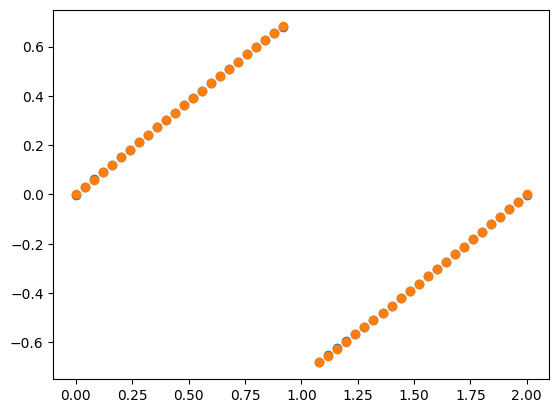

In [560]:
#x = np.linspace(0.0, 2.0, 50)                                  
t = np.linspace(1.0, 1.0, 1)                                        
t_grid, x_grid = np.meshgrid(t, x)                              
T = t_grid.flatten()[:, None]                                   
X = x_grid.flatten()[:, None]                                   
x_test = np.hstack((T, X))                                      
x_test = torch.tensor(x_test, requires_grad=True, dtype=torch.float32).to(device)
u_pred = to_numpy(pinn.net(x_test))
#res = to_numpy(model.res_pde(x_test))
#d   = to_numpy(model.lambda_pde(x_test))

#loss = model.loss_pde(x_test)                                 

import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x,u_pred[:,0])
plt.scatter(x,ur)
plt.show()

# Refrence results

In [559]:
f = open('result.dat','r')
datae=[]
for i in f:
    i=i.strip('\n').split(" ")
    datae.append([float(t) for t in i])
#ref = np.zeros((10001,2))
x = []
ur =[]
#for i in range(10001):
#    xd =  datae[i][0]
#    ud =  datae[i][1]
for i in range(51):
    xd =  datae[i*200][0]
    ud =  datae[i*200][1]
    if (xd > 1.05 or xd < 0.95):
        x = np.append(x,xd)
        ur = np.append(ur,ud)

In [270]:
np.size(ur[:])

50

In [561]:
np.linalg.norm(u_pred[:,0] - ur[:], 2)/np.linalg.norm(ur[:], 2)

0.0005345465739167206

# Result

| Hidden layers | $N_f$ | $N_{ib}$ |Learning rate | $\varepsilon_1 $| $\varepsilon_2$|$L_2$ Error| Total   Loss| $L_2$ Error Orign| Total Loss Orign|
|--|--|-- |--        | --       |--  |--       | -- | -- |  --|
|$3 \times 30 \times 30$| $50\times 50$| 50| 1.0| 10 | 0.1| $5.1\times 10^{-4} $|  $7.3\times 10^{-6}$| $ 2.3\times 10^{-2}  $  | $ 8.7 \times 10^{-3}$|
|$\color{red}{ 3 \times 20 \times 20}$| $50\times 50$| 50| 1.0| 10 | 0.1| $1.1\times 10^{-3} $ |  $1.0\times 10^{-5}$| $3.0\times 10^{-2}$ | $8.2\times 10^{-3}$|
|$\color{red}{3 \times 40 \times 40}$| $50\times 50$| 50| 1.0| 10 | 0.1| $2.1\times 10^{-3} $ |  $8.2\times 10^{-6}$| $8.8\times 10^{-3}$ | $2.0\times 10^{-3}$|
|$3 \times 30 \times 30$| $\color{red}{100\times 100}$| $\color{red}{100}$| 1.0| 10 | 0.1| $5.0\times 10^{-4} $|  $4.8\times 10^{-5}$| $1.4 \times 10^{-2}$| $3.3\times 10^{-3}$|
|$3 \times 30 \times 30$| $\color{red}{25\times 25}$| $\color{red}{25}$| 1.0| 10 | 0.1| $1.8\times 10^{-3} $|  $6.0\times 10^{-6}$| $1.3 \times 10^{-2}$| $2.7\times 10^{-3}$|
|$3 \times 30 \times 30$| $50\times 50$| 50| $\color{red}{0.5}$| 10 | 0.1| $1.1\times 10^{-3} $|  $5.7\times 10^{-6}$| $ 7.2\times 10^{-3}  $  | $ 5.8 \times 10^{-4}$|
|$3 \times 30 \times 30$| $50\times 50$| 50| $\color{red}{1.5}$| 10 | 0.1| $7.0\times 10^{-4} $|  $2.2\times 10^{-5}$| $ 1.9\times 10^{-2}  $  | $ 4.0 \times 10^{-3}$|
|$3 \times 30 \times 30$| $50\times 50$| 50| 1.0| $\color{red}{20}$ | 0.1| $9.7\times 10^{-4} $|  $9.6\times 10^{-5}$| $ 1.1\times 10^{-2}  $  | $ 1.0 \times 10^{-3}$|
|$3 \times 30 \times 30$| $50\times 50$| 50| 1.0| $\color{red}{5}$ | 0.1| $7.2\times 10^{-4} $|  $1.6\times 10^{-5}$| $ 2.6\times 10^{-2}  $  | $ 5.5 \times 10^{-3}$|
|$3 \times 30 \times 30$| $50\times 50$| 50| 1.0| $10$ | $\color{red}{0.05}$| $7.1\times 10^{-4} $|  $3.0\times 10^{-5}$| $ 1.8\times 10^{-2}  $  | $ 3.6 \times 10^{-3}$|
|$3 \times 30 \times 30$| $50\times 50$| 50| 1.0| $10$ | $\color{red}{0.2}$| $1.2\times 10^{-3} $|  $9.2\times 10^{-5}$| $ 1.8\times 10^{-2}  $  | $ 3.6 \times 10^{-3}$|


# Output

In [124]:
new_array = np.array(u_pred[:,0])
file = open("burgers_u_we_11500.dat", "w+")
for i in range(u_pred.shape[0]):
    print(f'{x[i]}  {u_pred[i,0]} ',file=file)
file.close()

In [14]:
new_array = np.array(res[:,0])
file = open("burgers_res_w_5000.dat", "w+")
for i in range(u_pred.shape[0]):
    print(f'{x[i]}  {res[i,0]} ',file=file)
file.close()

In [57]:
file = open("burgers_d_w_14931.dat", "w+")
for i in range(d.shape[0]):
    print(f'{x[i]}  {1/d[i,0]} ',file=file)
file.close()